In [226]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from math import ceil


In [222]:
state_df = pd.read_csv('./data/states.csv')
state_df.date = pd.to_datetime(state_df.date, yearfirst = True, format = '%Y%m%d')
state_df.date = state_df.date.dt.strftime('%m/%d')
state_df.sort_values('date',inplace=True)
state_df.head()

date state  positive  negative  pending  hospitalizedCurrently  \
5784  01/22    WA       1.0       NaN      NaN                    NaN   
5783  01/23    WA       1.0       NaN      NaN                    NaN   
5782  01/24    WA       1.0       NaN      NaN                    NaN   
5781  01/25    WA       1.0       NaN      NaN                    NaN   
5780  01/26    WA       1.0       NaN      NaN                    NaN   

      hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
5784                     NaN             NaN              NaN   
5783                     NaN             NaN              NaN   
5782                     NaN             NaN              NaN   
5781                     NaN             NaN              NaN   
5780                     NaN             NaN              NaN   

      onVentilatorCurrently  ...  posNeg  deathIncrease hospitalizedIncrease  \
5784                    NaN  ...       1              0                    0   
5783                    NaN  ...       1              0                    0   
5782                    NaN  ...       1              0                    0   
5781                    NaN  ...       1              0                    0   
5780                    NaN  ...       1              0                    0   

                                          hash commercialScore  \
5784  2d109d8ba4c74e86fa7202b7c9f26c7617945c58               0   
5783  7ed011fe93129bbc13213e7028e7e1e299d67691               0   
5782  488430e6f0d933476ca2120fe0ee2ecf4aac5b94               0   
5781  4a8a13ff65ef1f0bb991324d98609c765c5b5849               0   
5780  5372bd69fec11b6097c548b149e4e79fca8d21d2               0   

     negativeRegularScore  negativeScore  positiveScore score  grade  
5784                    0              0              0     0    NaN  
5783                    0              0              0     0    NaN  
5782                    0              0              0     0    NaN  
5781                    0              0              0     0    NaN  
5780                    0              0              0     0    NaN  

[5 rows x 39 columns]

In [154]:
population_dict = {}
with open('./data/populations.tsv','r') as f:
    for line in f:
        line = line.strip().split('\t')
        population_dict[line[0]] = int(line[1])

In [230]:
def plot_individual_state(state, output_file = None, rollingwindow = 7, df = state_df, pop_dict = population_dict):
    fig,ax = plt.subplots(figsize = (20,10))
    ax2 = ax.twinx()
    state_pop = pop_dict[state]

    tmp = df.loc[df.state==state,:].copy()
    tmp.loc[:,'deltapos'] = tmp['positive'].diff()
    tmp.loc[:,'deltapos.rolling'] = tmp['deltapos'].rolling(rollingwindow).mean()
    tmp.loc[:,'deltatest'] = tmp['totalTestResults'].diff()
    tmp.loc[:,'deltatest.rolling'] = tmp['deltatest'].rolling(rollingwindow).mean()
    rate = tmp['deltapos.rolling']/tmp['deltatest.rolling']
    ax2.plot(tmp.date, rate , lw = 2, color = '#aaaaaa',zorder = 1)
    ax2.scatter(tmp.date, rate , color = ['#0066cc' if x<0.05 else '#cc0000' for x in rate], s = 40, zorder = 3, edgecolor = 'k')
    ax2.set_ylim([0,0.5])
    ax.bar(tmp.date,tmp['deltapos.rolling']/state_pop*1000,color = 'k',zorder = 3)
    ax.bar(tmp.date,tmp['deltatest.rolling']/state_pop*1000, color = '#FFC900', edgecolor = 'k')

    ax.set_title(state)
    ax.set_ylim([0,4])
    ax.xaxis.set_major_locator(mdates.DayLocator(interval = 10))
    if output_file:
        plt.savefig(output_file)
    plt.show()

In [246]:
def plot_multiple_states(states, output_file = None, rollingwindow = 7, df = state_df, pop_dict = population_dict):
    num_states = len(states)
    num_rows = ceil(num_states/3)
    fig,ax = plt.subplots(num_rows,3,figsize = (40,7*num_rows))
    ax = ax.flatten()

    states = sorted(states)
    for i,state in enumerate(states):
        ax2 = ax[i].twinx()
        state_pop = population_dict[state]

        tmp = df.loc[df.state==state,:].copy()
        tmp.loc[:,'deltapos'] = tmp['positive'].diff()
        tmp.loc[:,'deltapos.rolling'] = tmp['deltapos'].rolling(7).mean()
        tmp.loc[:,'deltatest'] = tmp['totalTestResults'].diff()
        tmp.loc[:,'deltatest.rolling'] = tmp['deltatest'].rolling(7).mean()
        rate = tmp['deltapos.rolling']/tmp['deltatest.rolling']
        ax2.plot(tmp.date, rate , lw = 2, color = 'k',zorder = 1)
        ax2.scatter(tmp.date, rate , color = ['#0066cc' if x<0.05 else '#cc0000' for x in rate], s = 40, zorder = 3, edgecolor = 'k')
        ax2.set_ylim([0,0.5])
        ax[i].bar(tmp.date,tmp['deltapos.rolling']/state_pop*1000,color = 'k',zorder = 3)
        ax[i].bar(tmp.date,tmp['deltatest.rolling']/state_pop*1000, color = '#FFC900', edgecolor = 'k')

        ax[i].set_title(state)
    for a in ax:
        (ymin,ymax) = a.get_ylim()
        a.set_ylim([0,ymax])
        a.xaxis.set_major_locator(mdates.DayLocator(interval = 10))
    plt.tight_layout()
    if output_file:
        plt.savefig(output_file)
    plt.show()

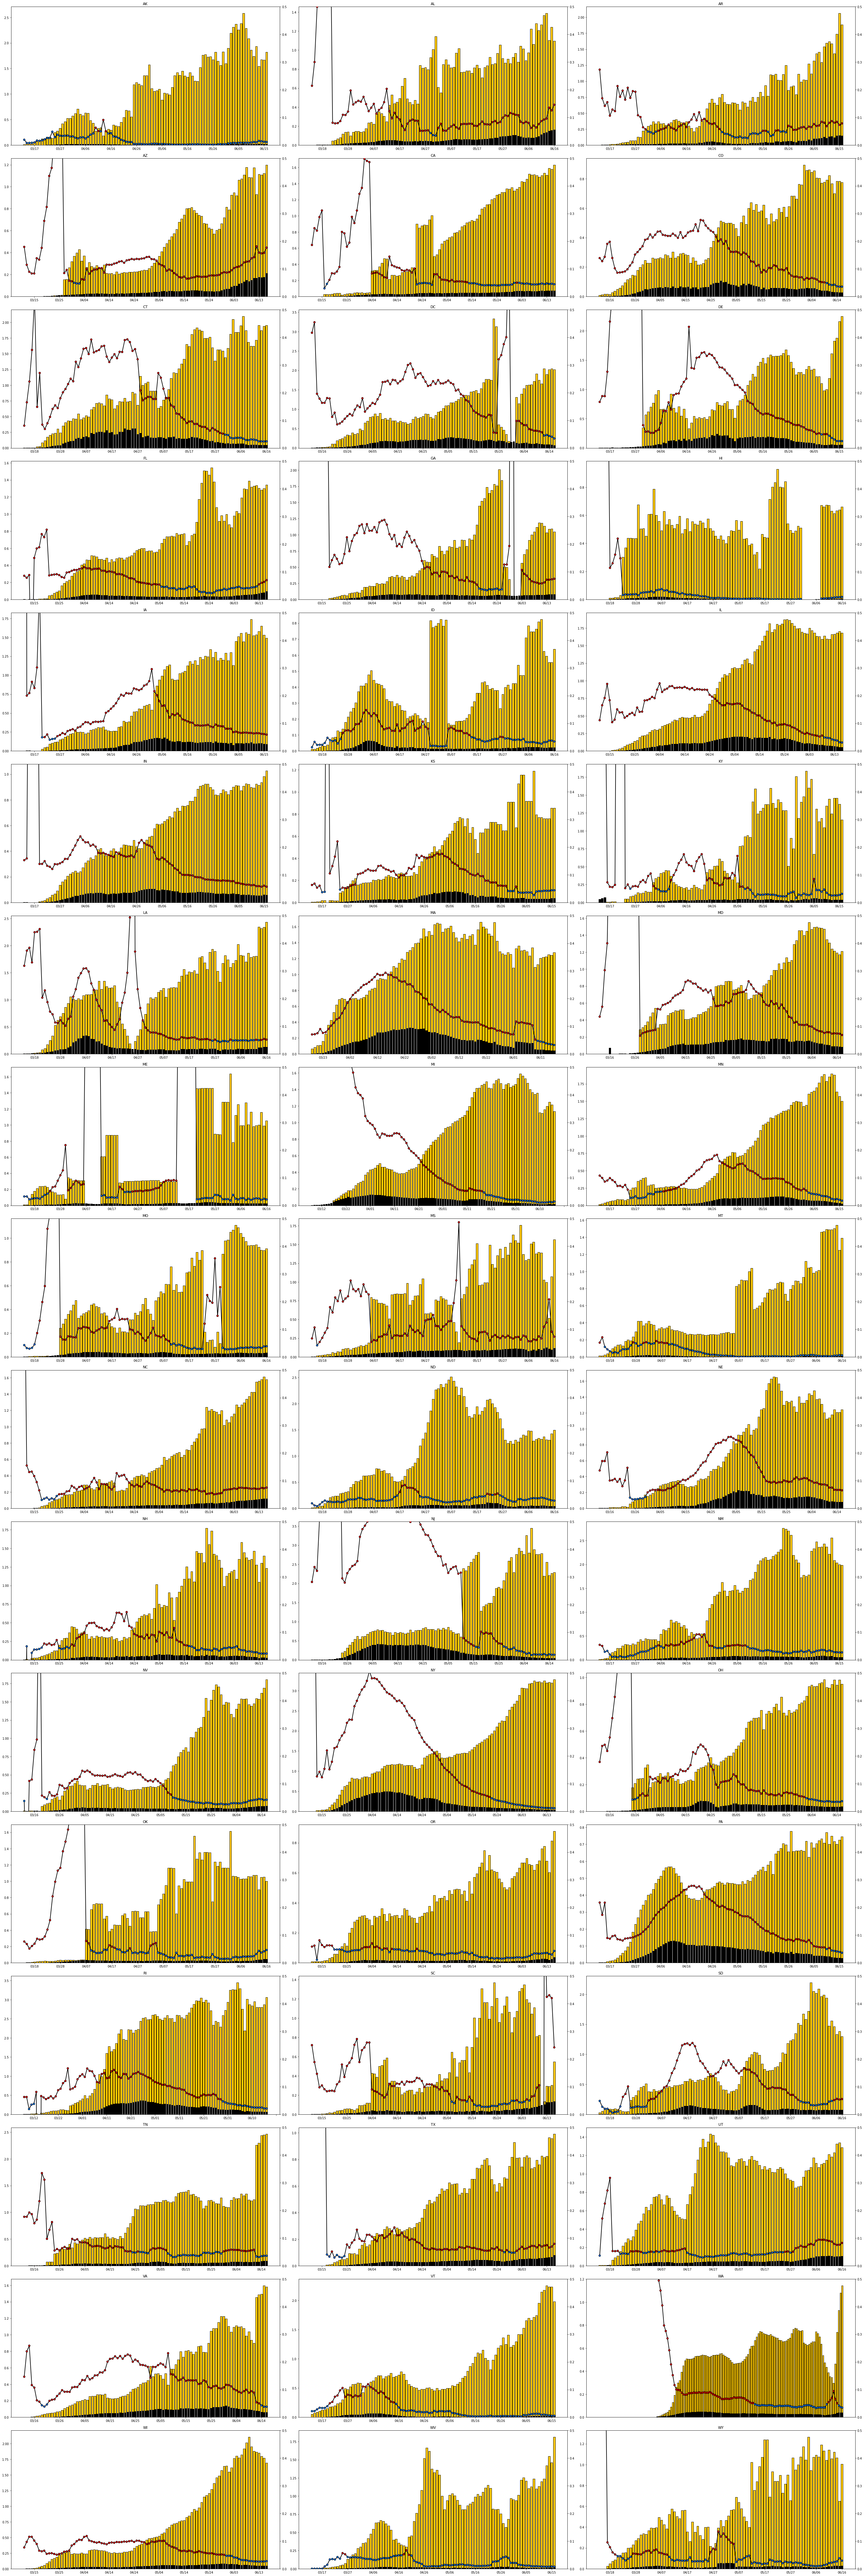

In [247]:
states_dc = [x for x in df.state.unique() if x not in ['PR','GU','AS','MP','VI']]
plot_multiple_states(states_dc, output_file='AllStates.png')

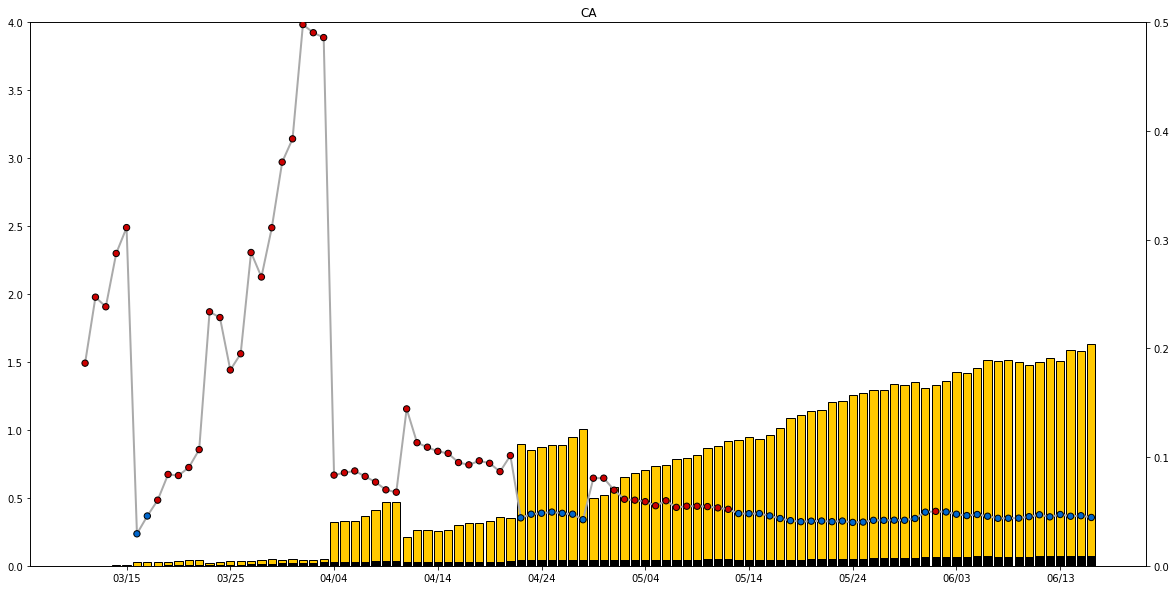

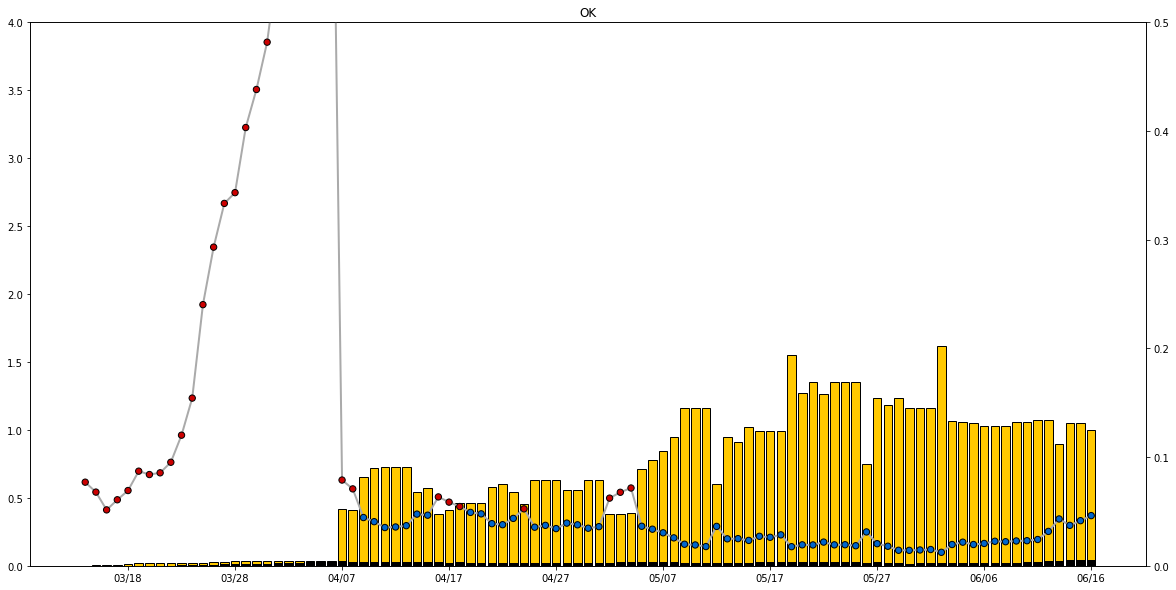

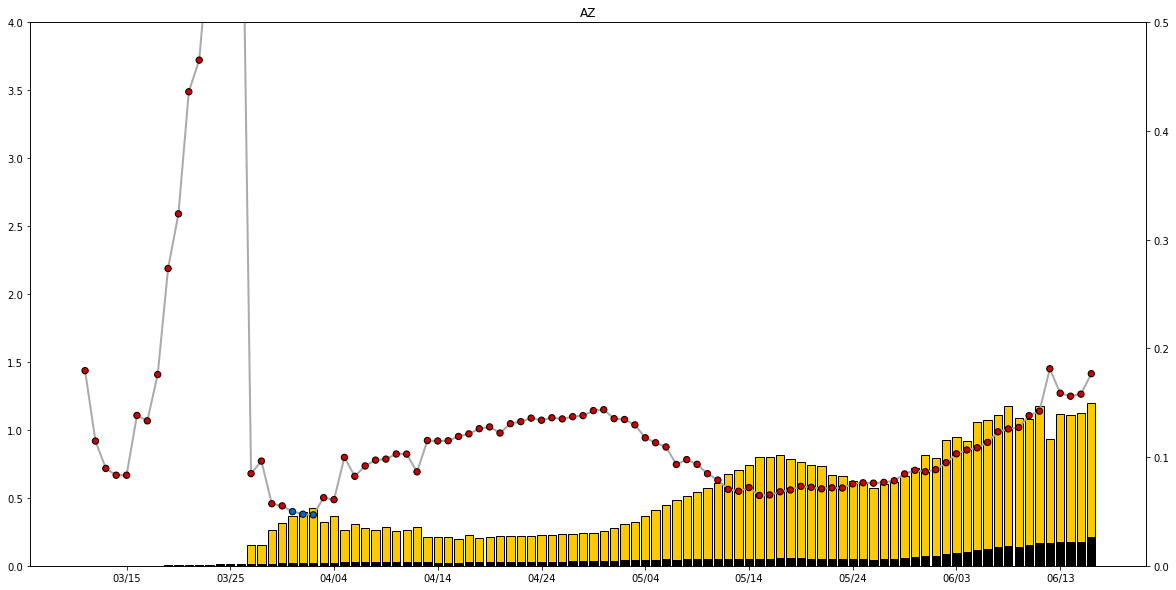

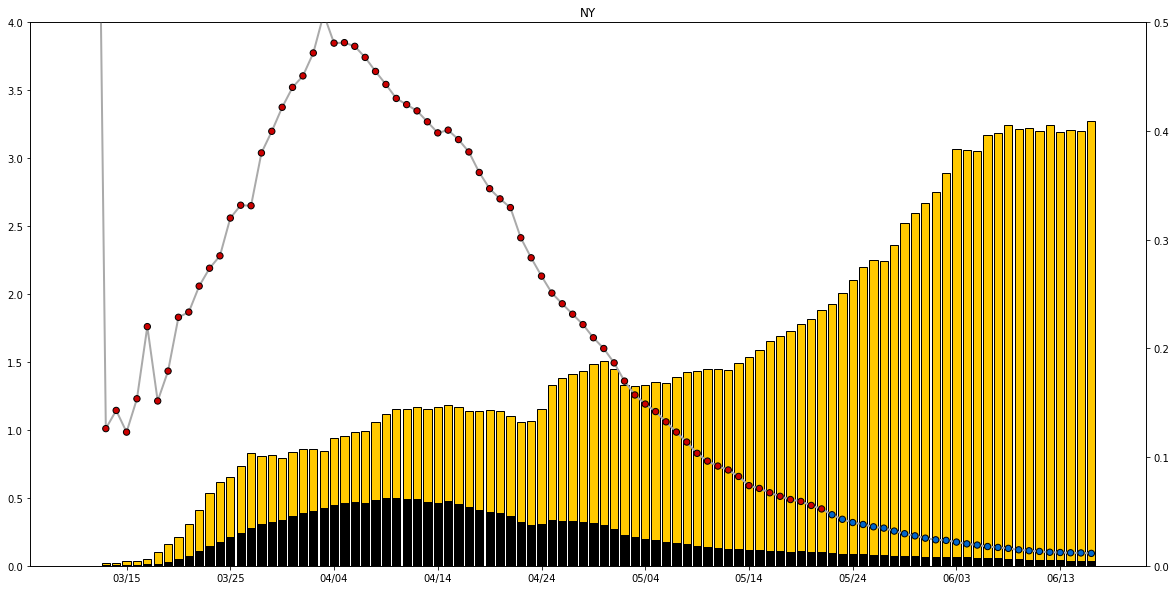

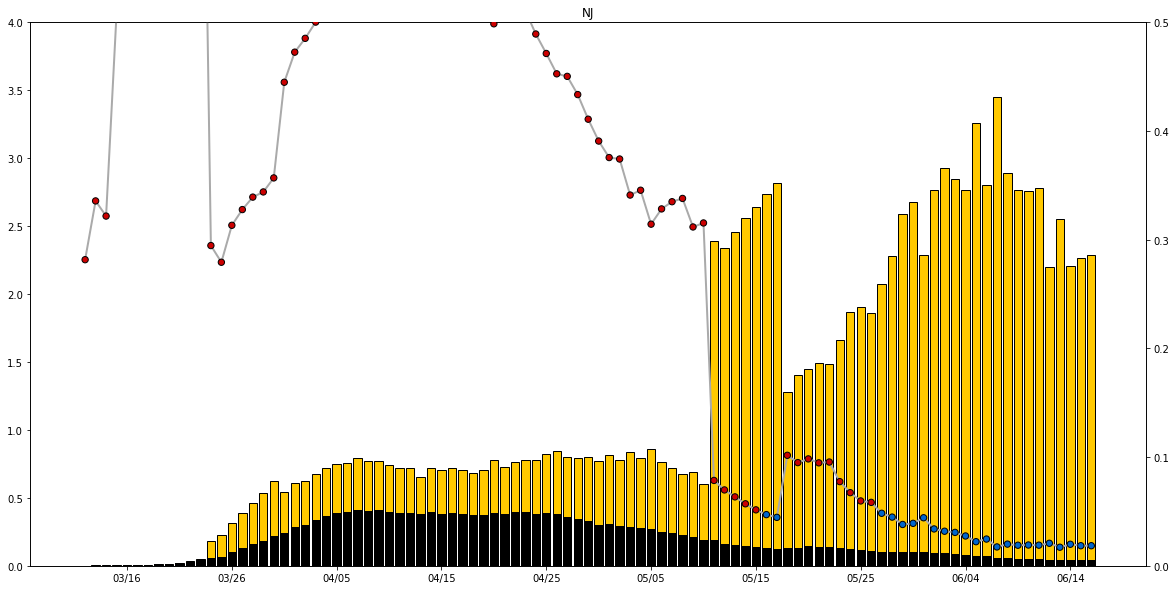

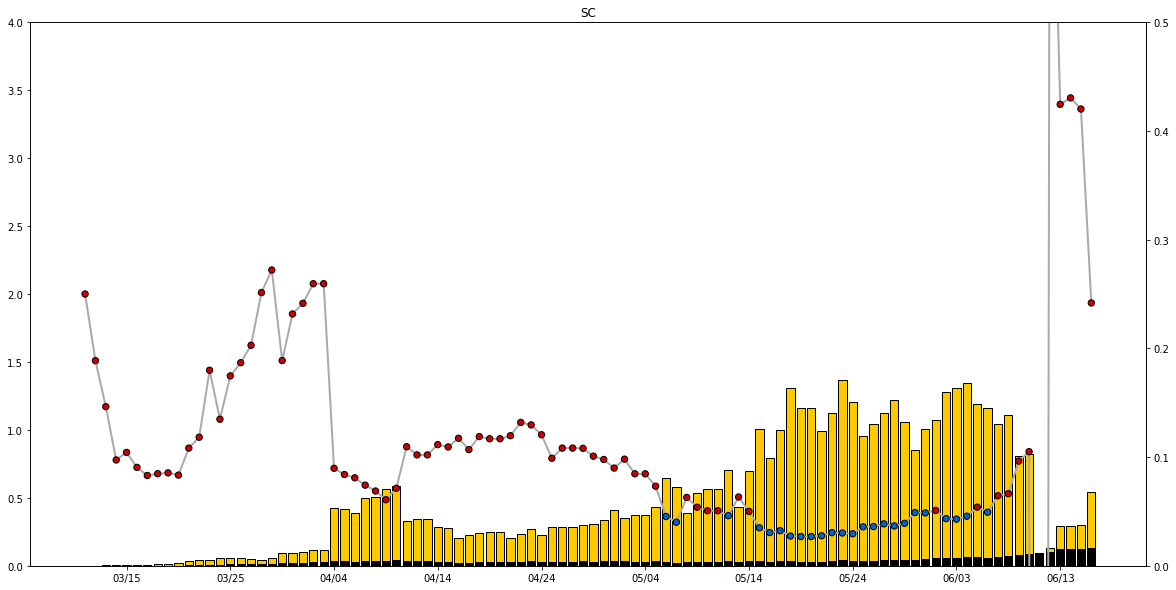

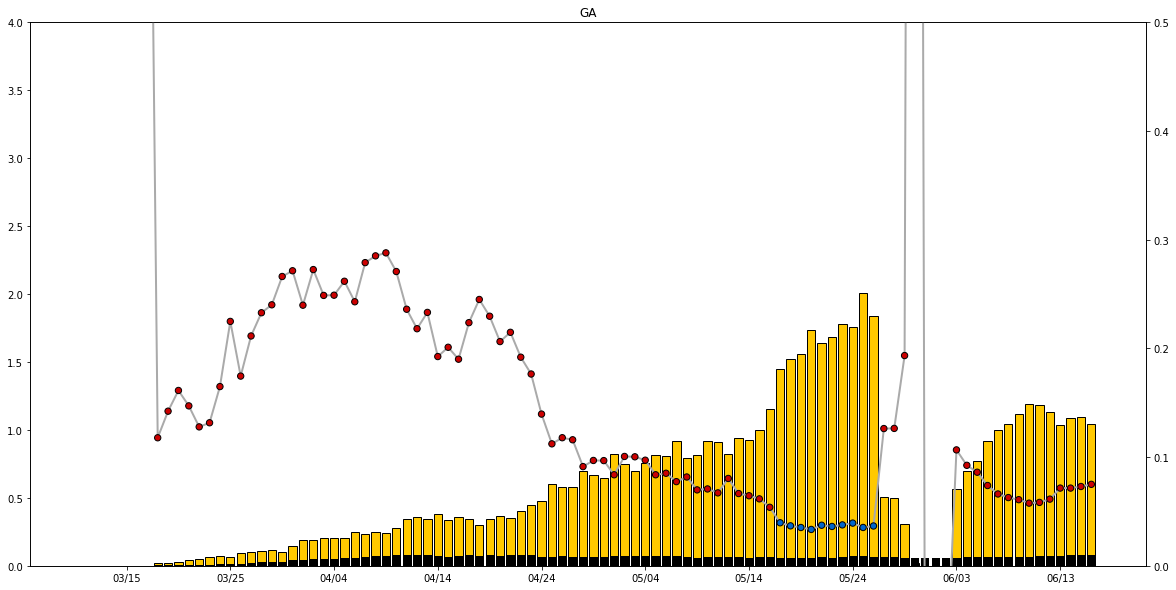

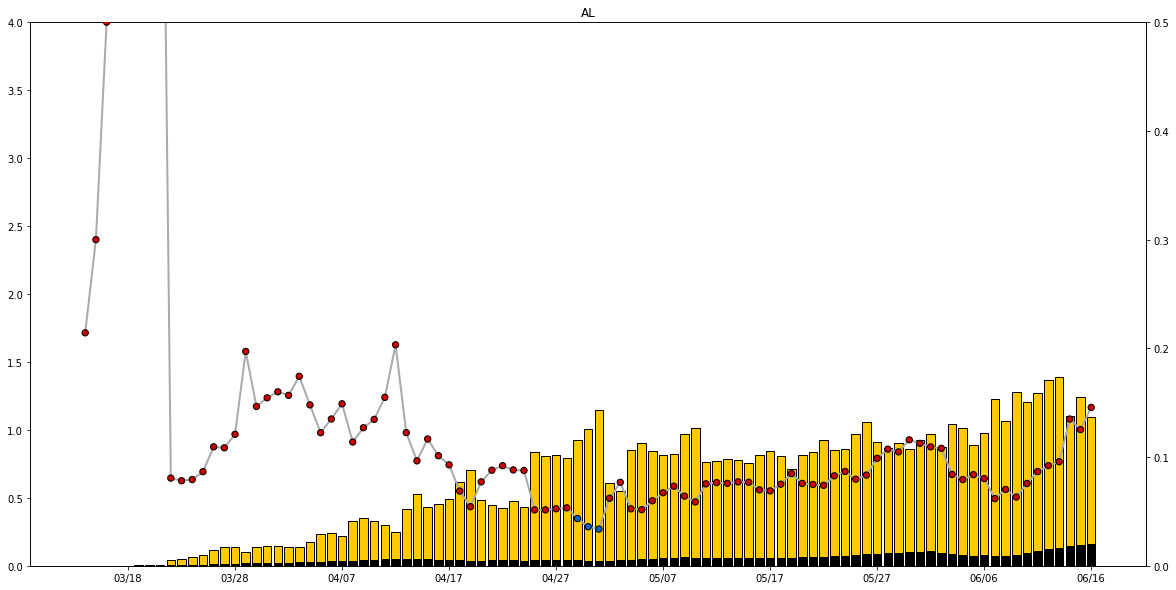

In [249]:
for state in ['CA','OK','AZ','NY','NJ','SC','GA','AL']:
    plot_individual_state(state, output_file = './plots/{}.png'.format(state))

# Plotly old code, maybe revisit for interactive plots

In [59]:
fig = make_subplots()
fig.add_trace(go.Scatter(x = df.date, y = df['deltapos.rolling']/df['deltatest.rolling']))
fig.write_html('first_figure.html', auto_open=True)

/home/hoooman/covid_plots/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/hoooman/covid_plots/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/hoooman/covid_plots/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

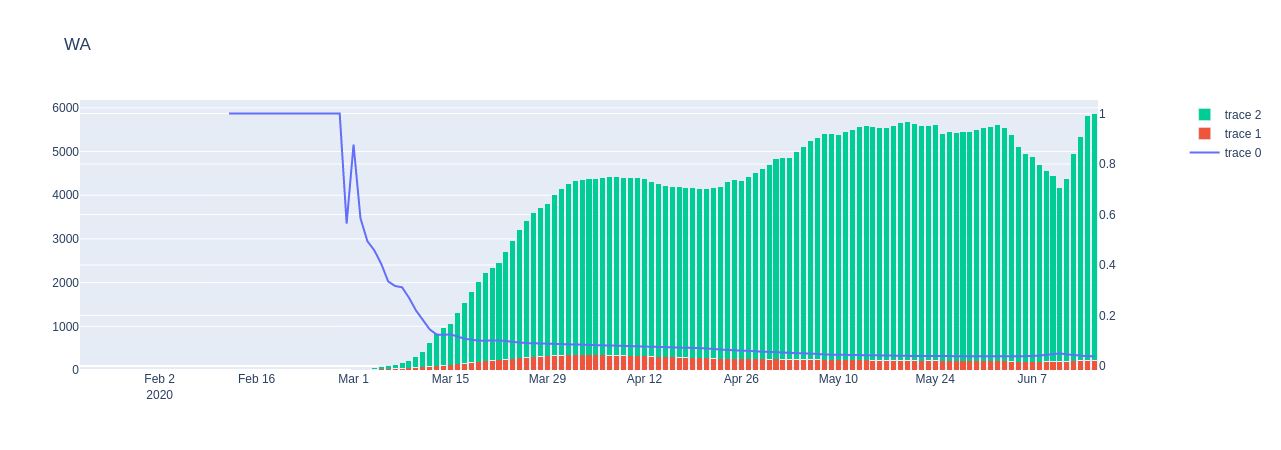

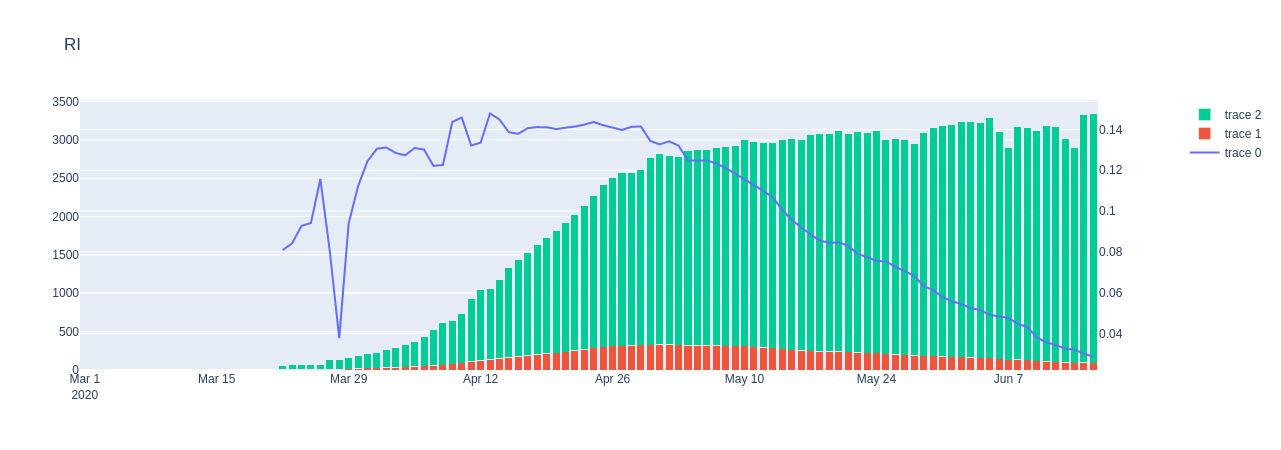

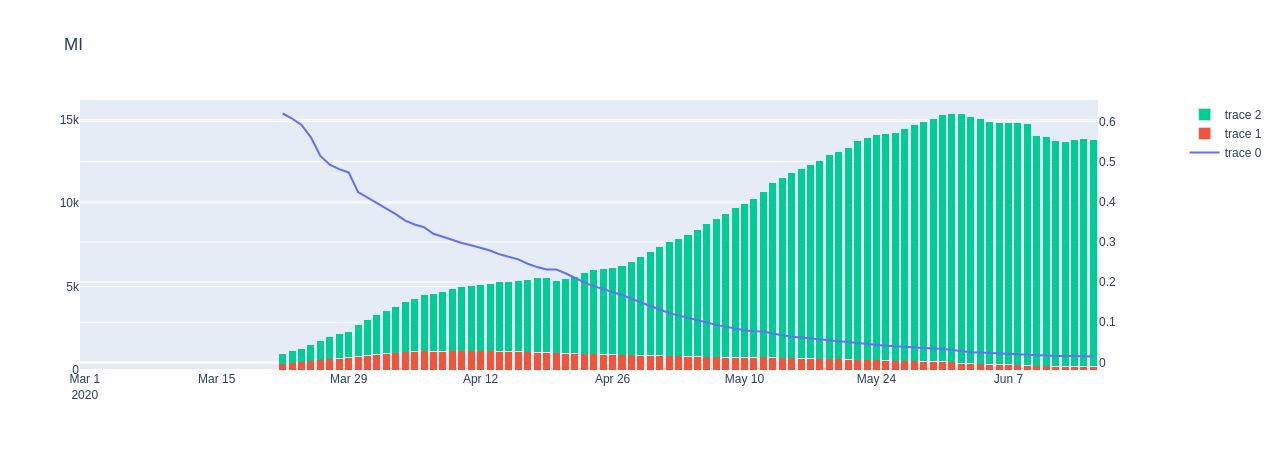

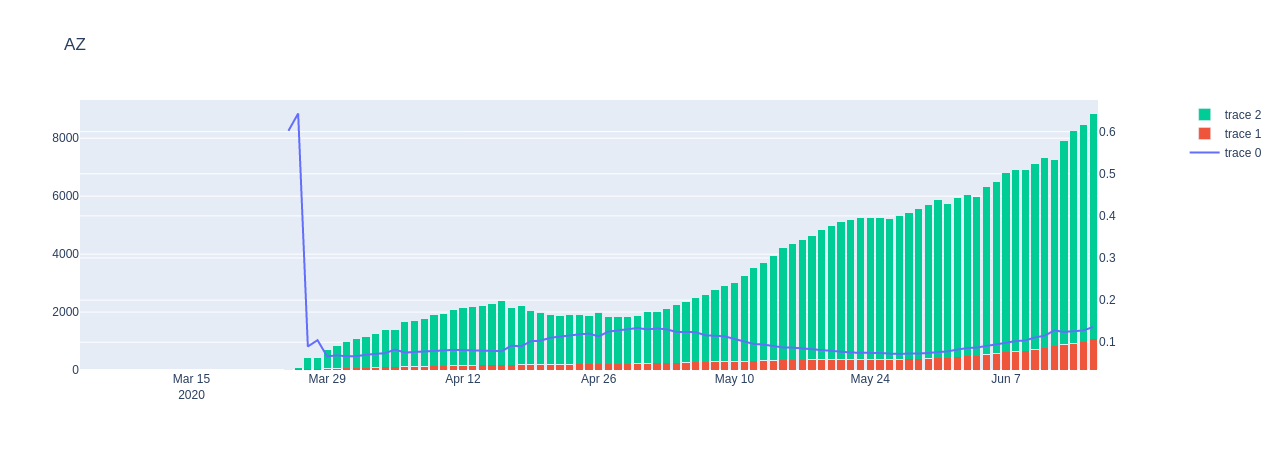

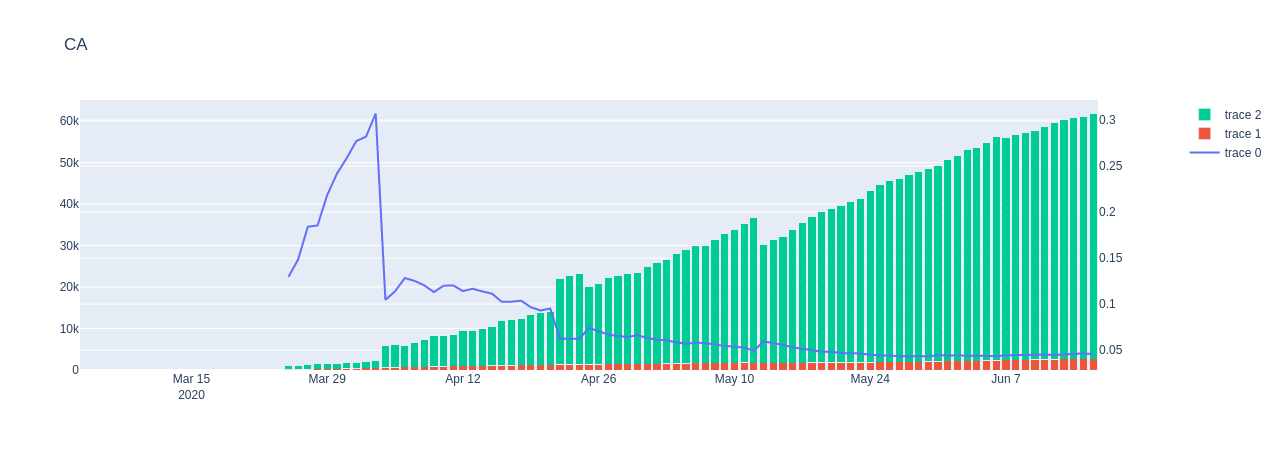

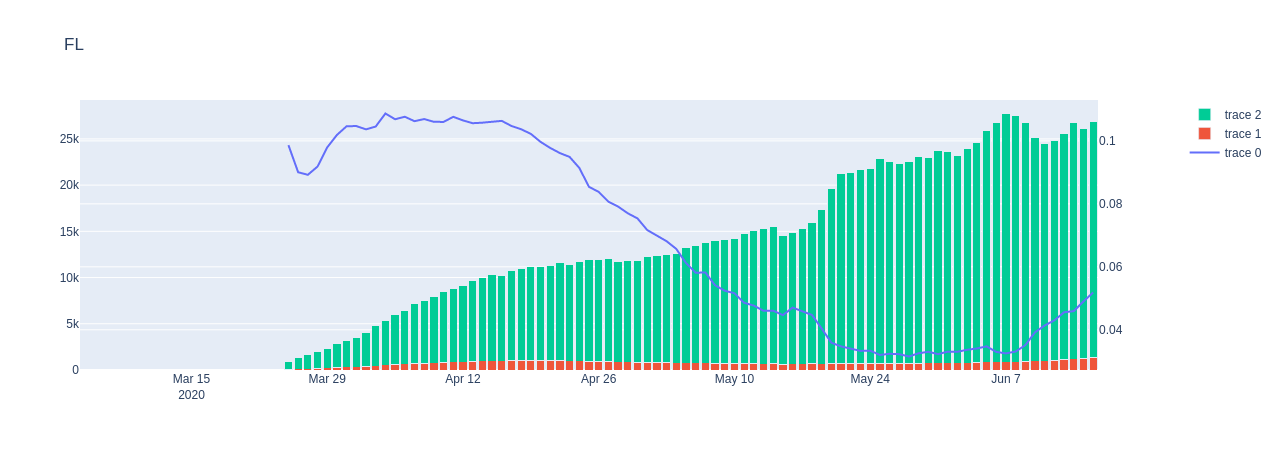

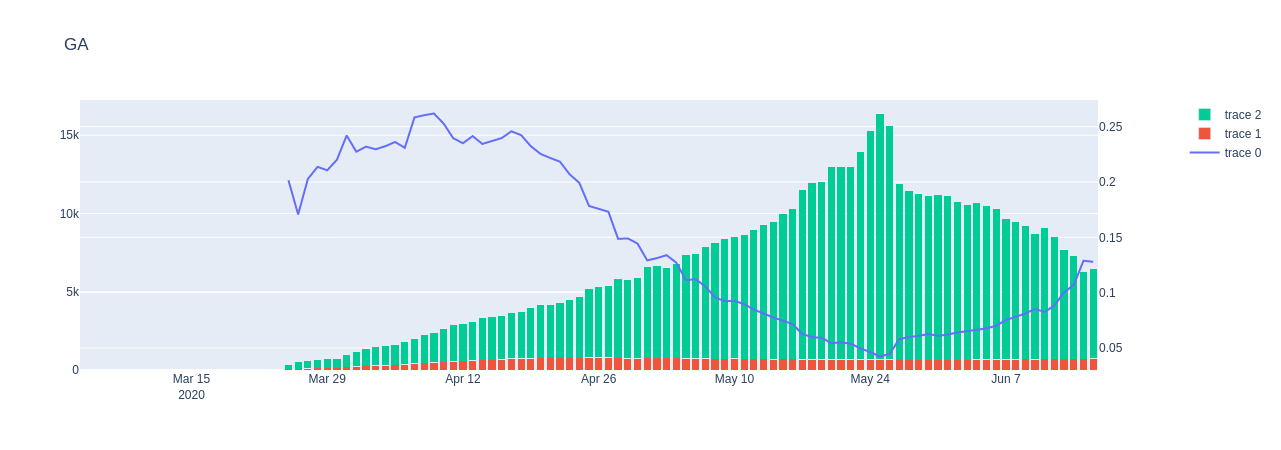

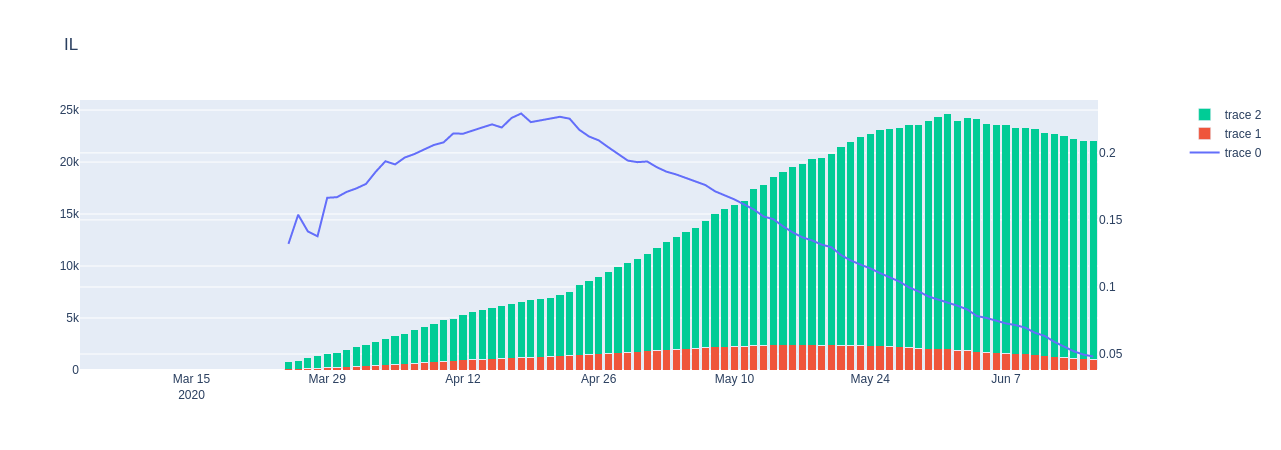

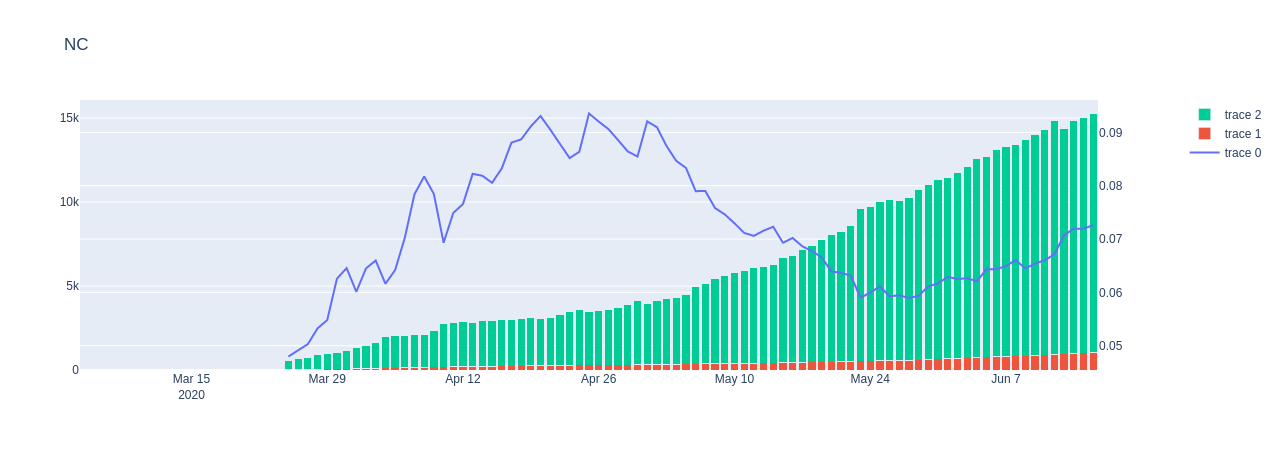

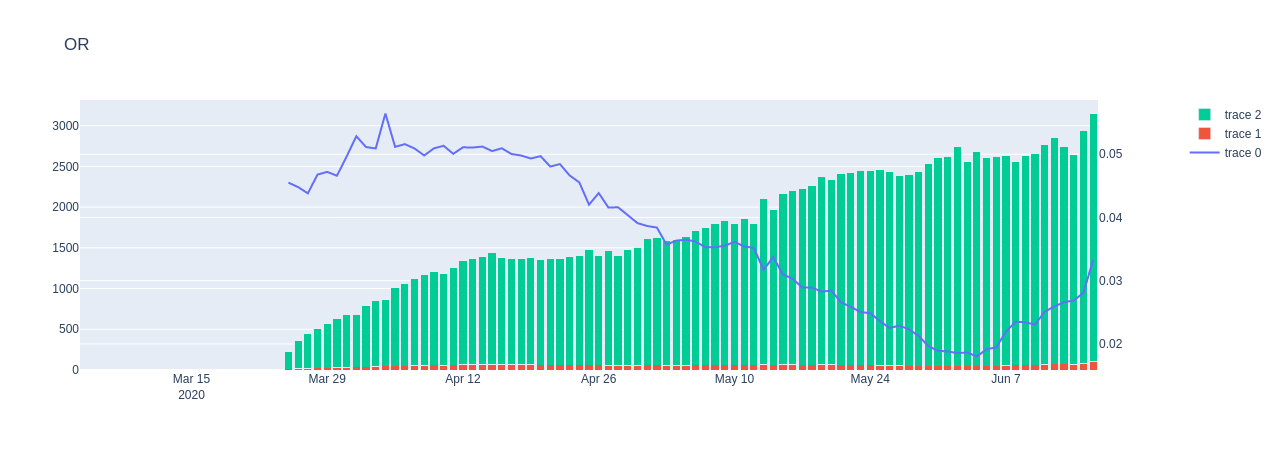

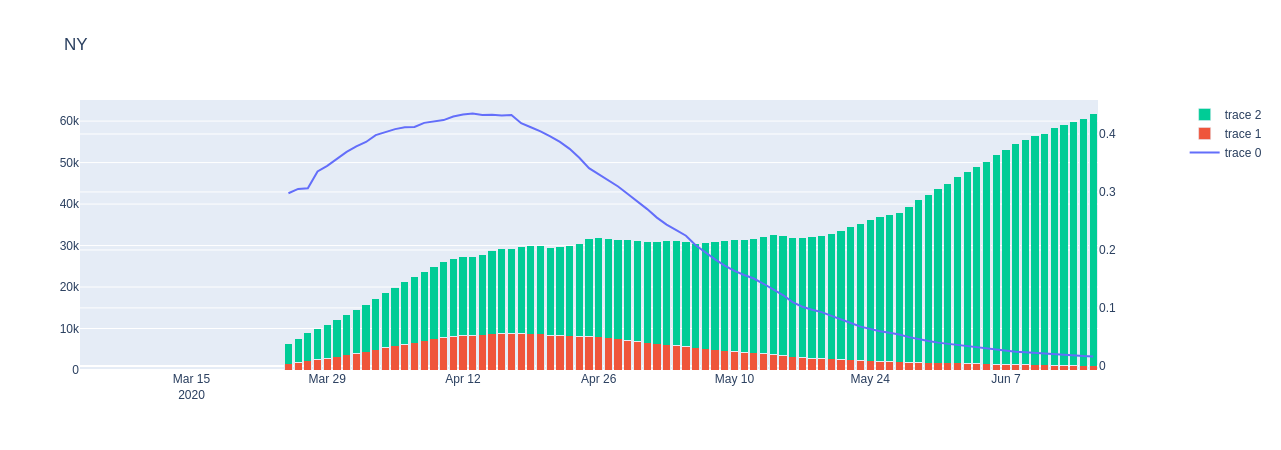

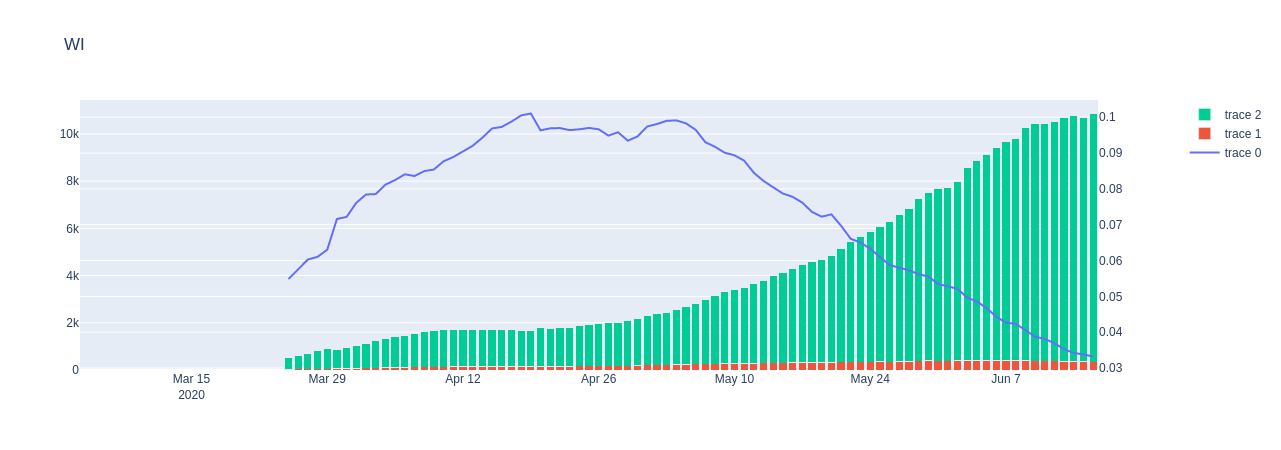

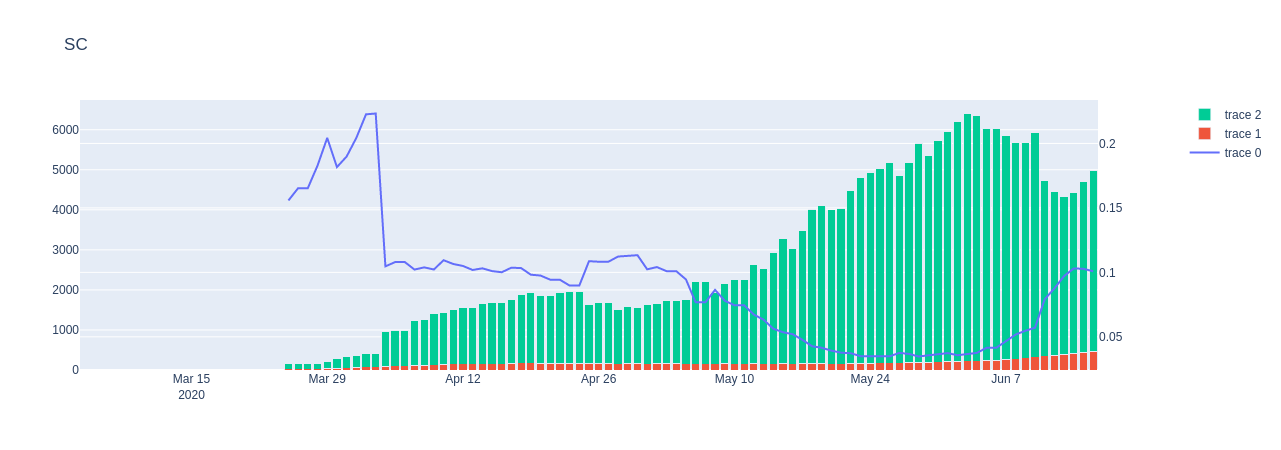

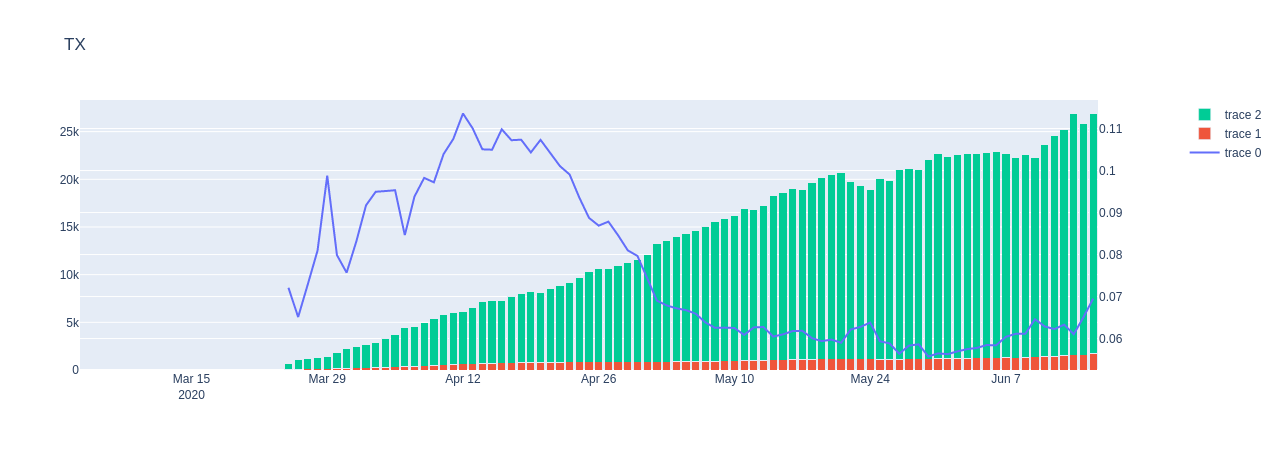

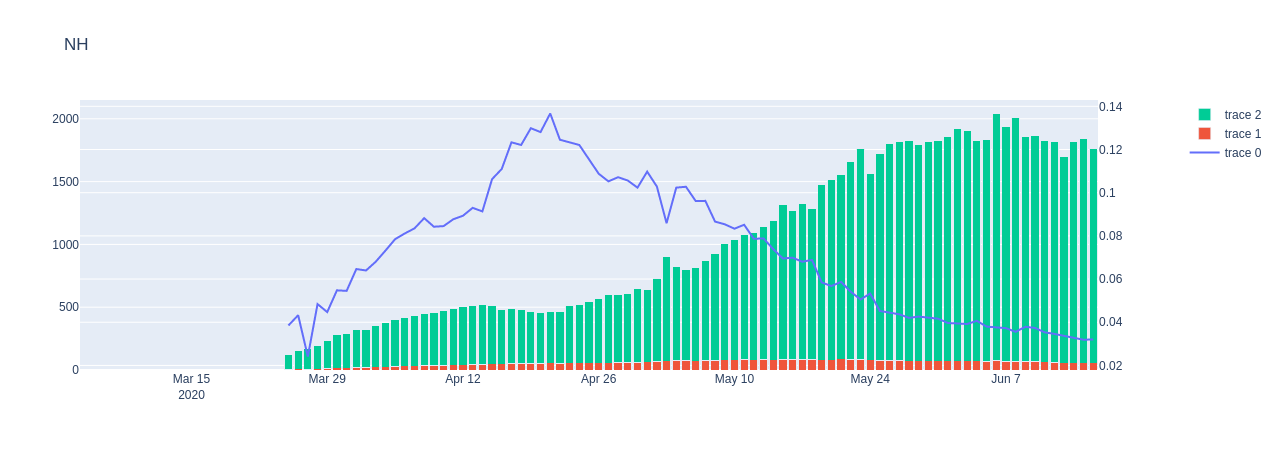

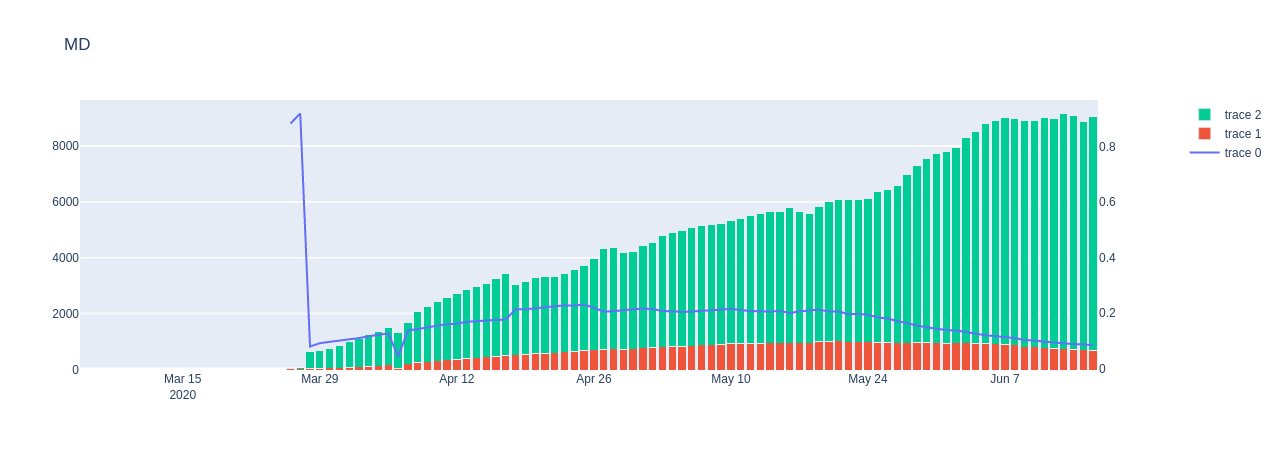

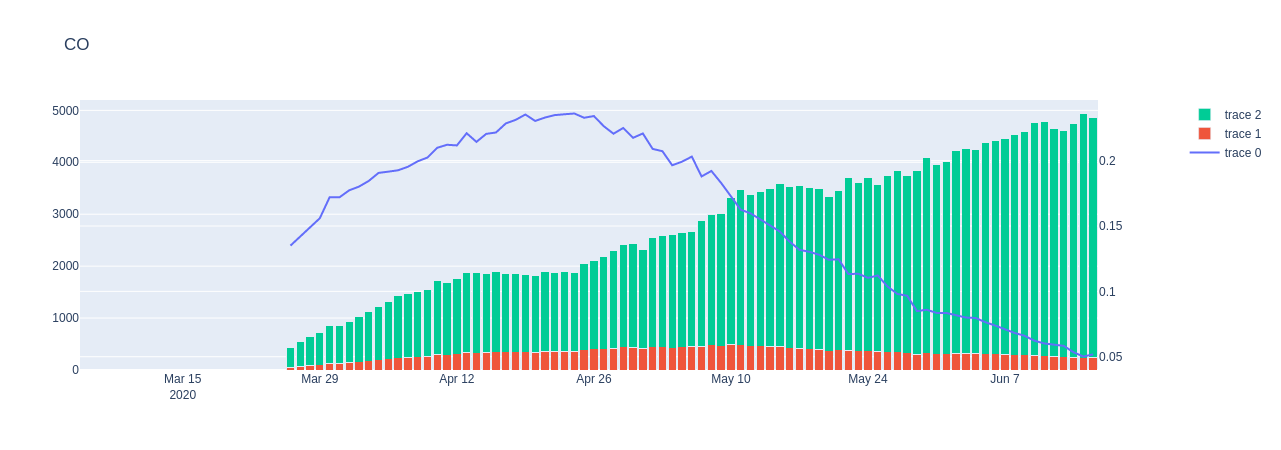

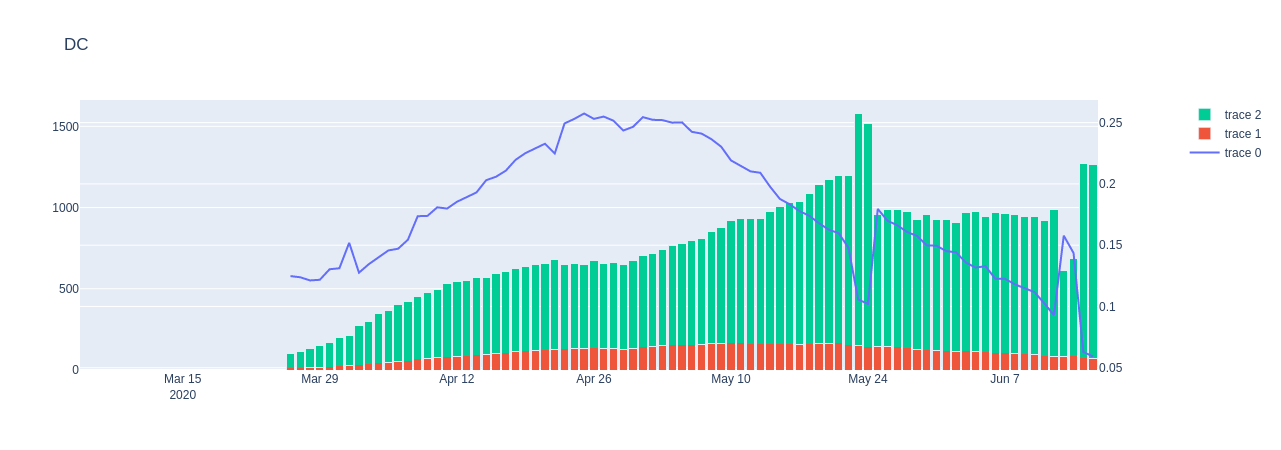

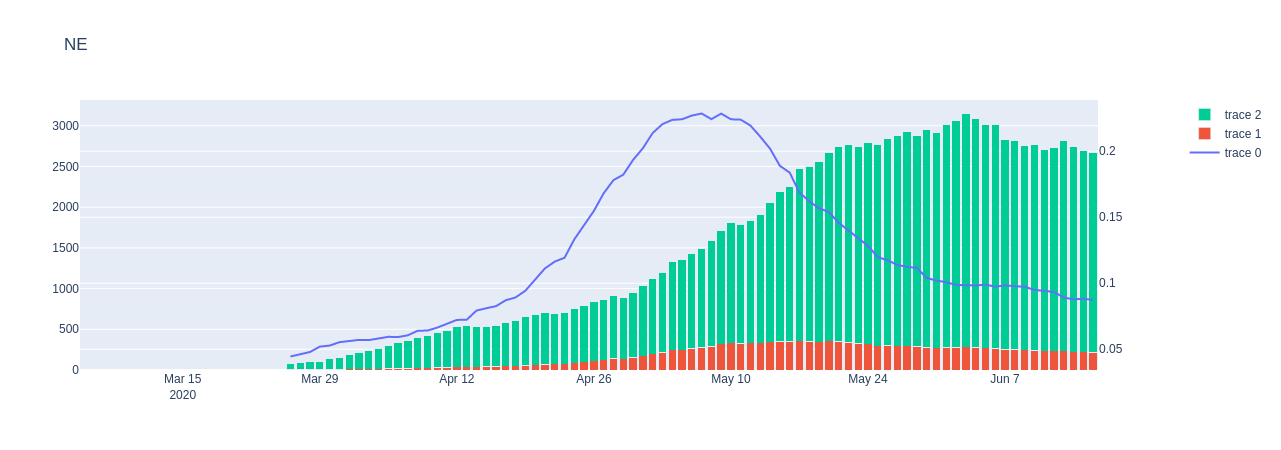

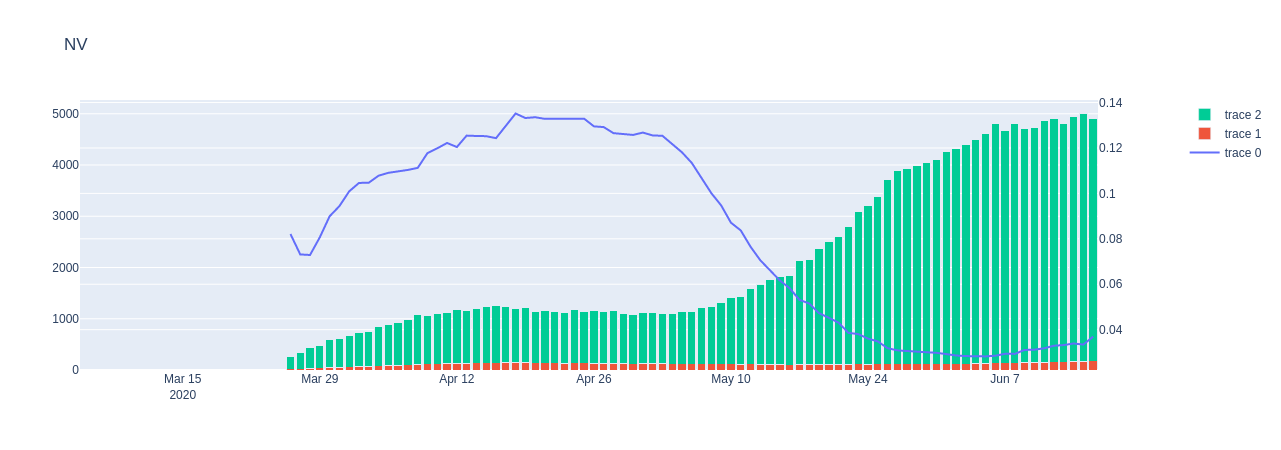

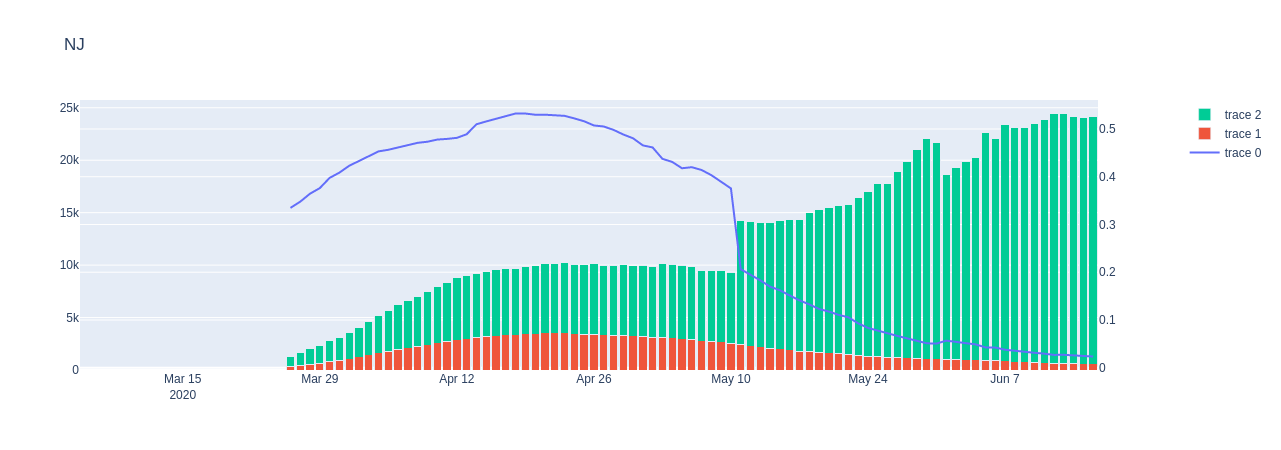

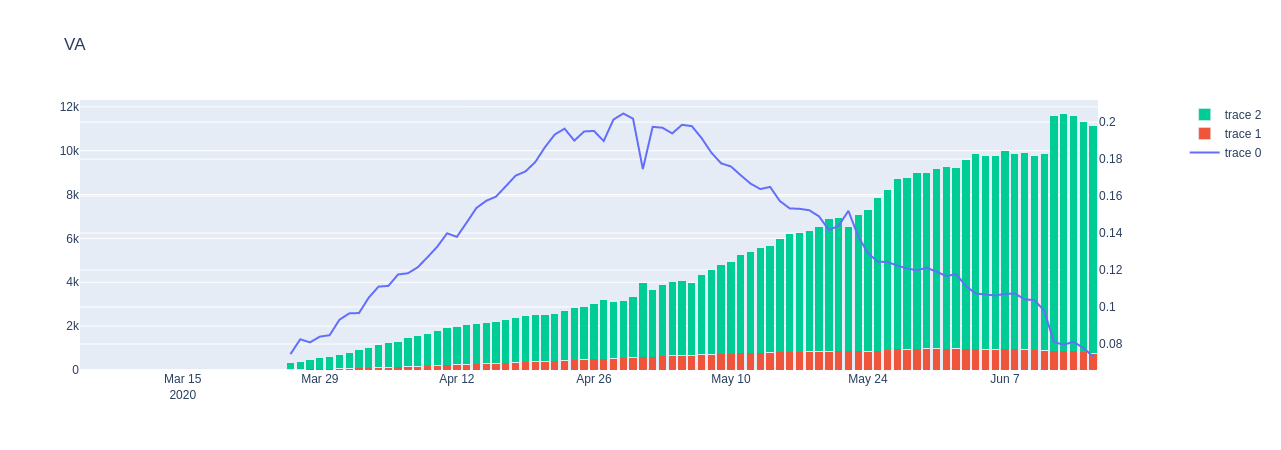

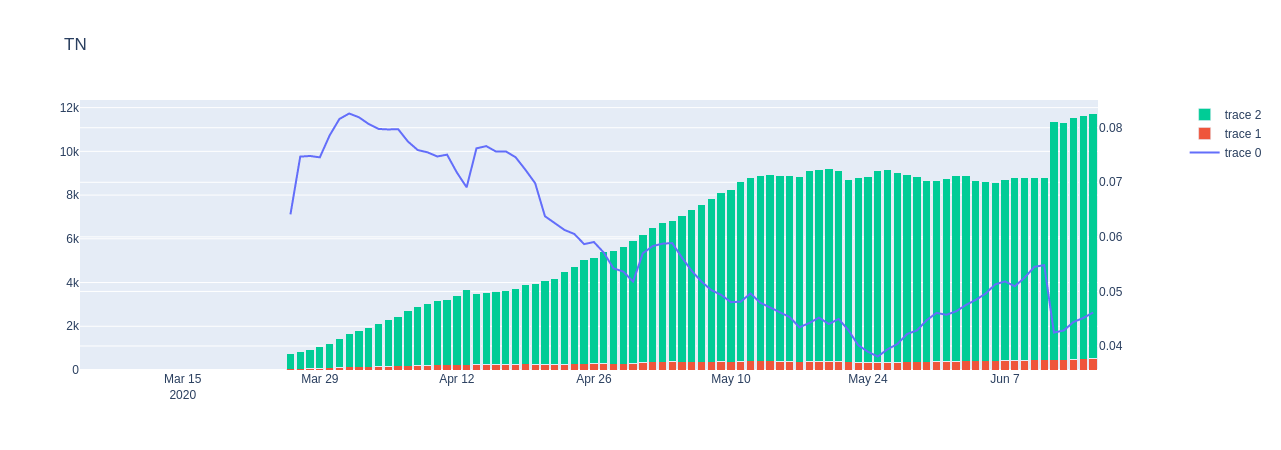

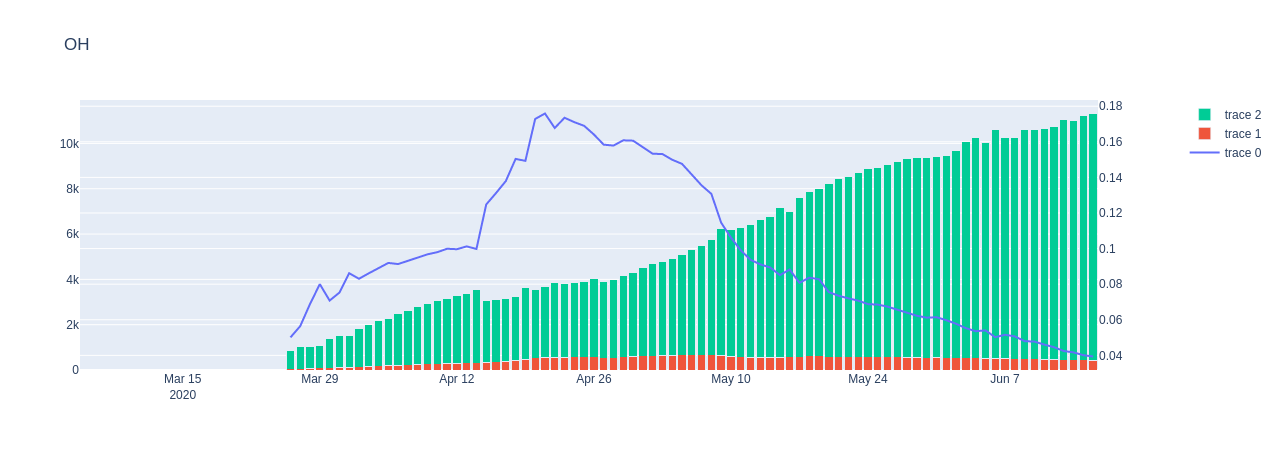

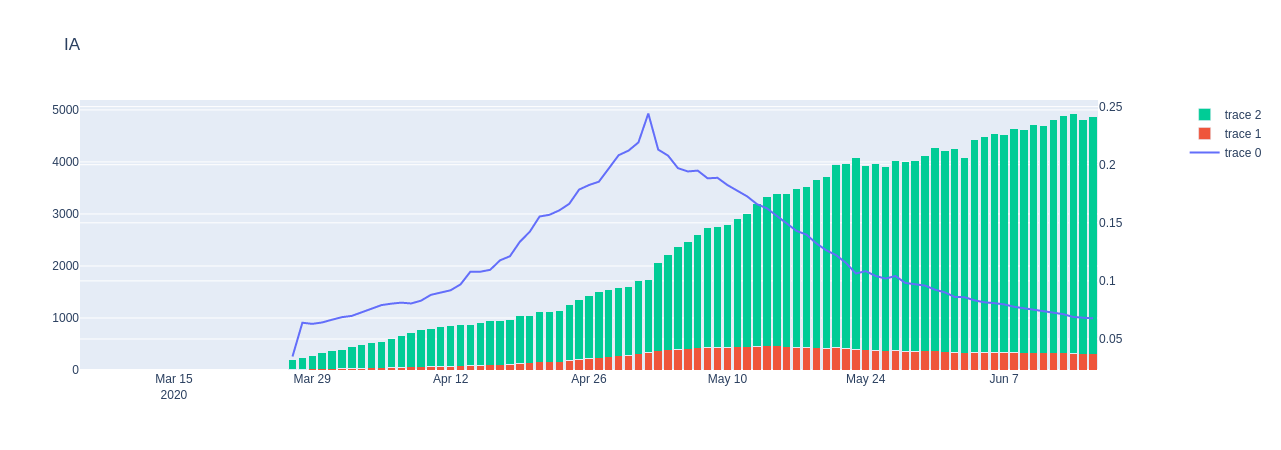

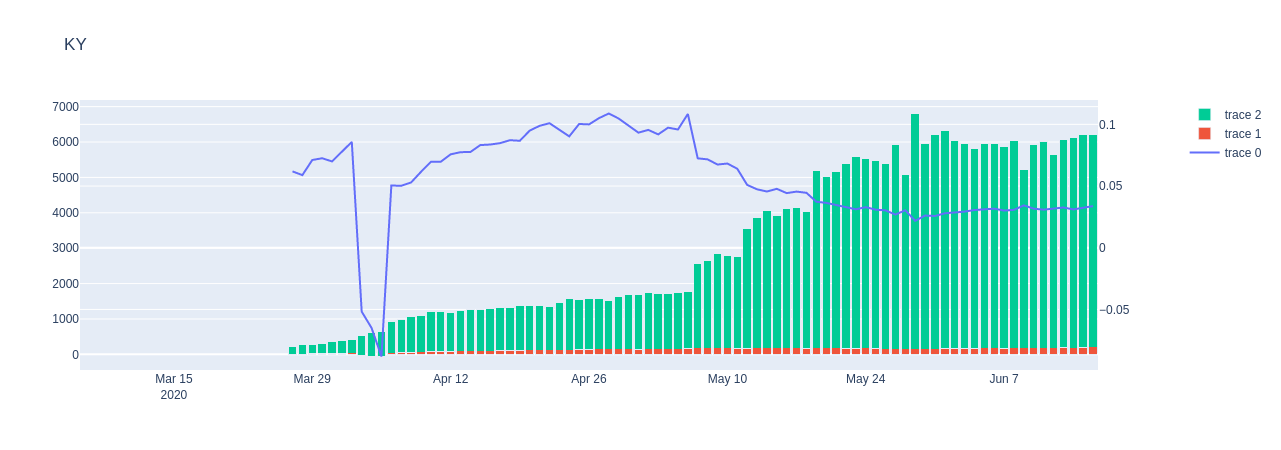

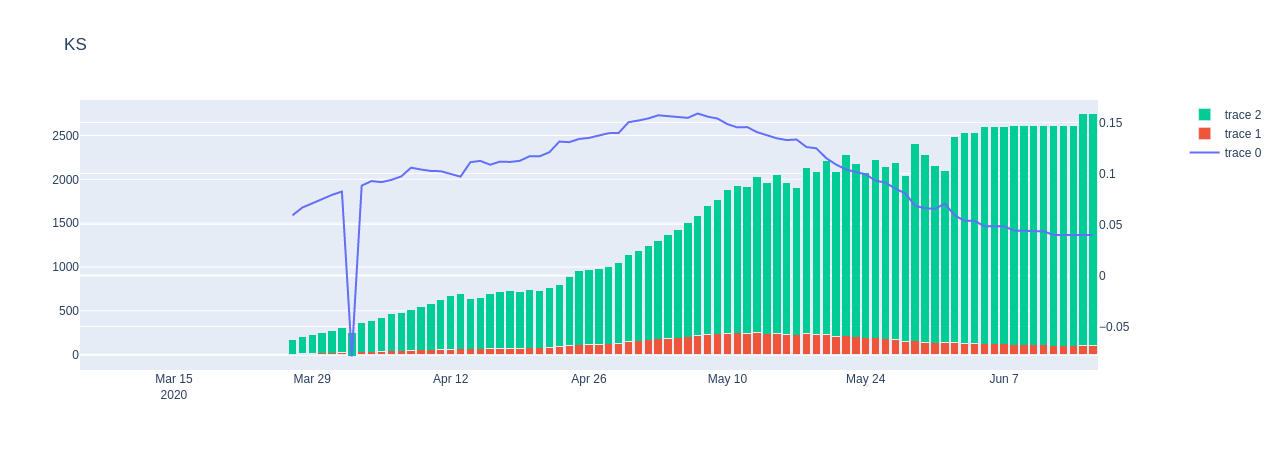

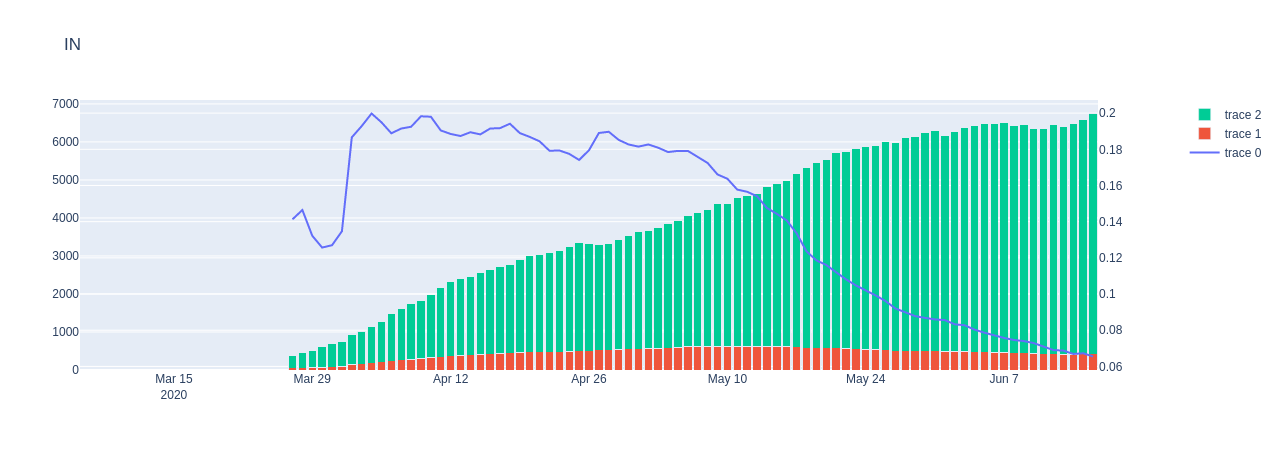

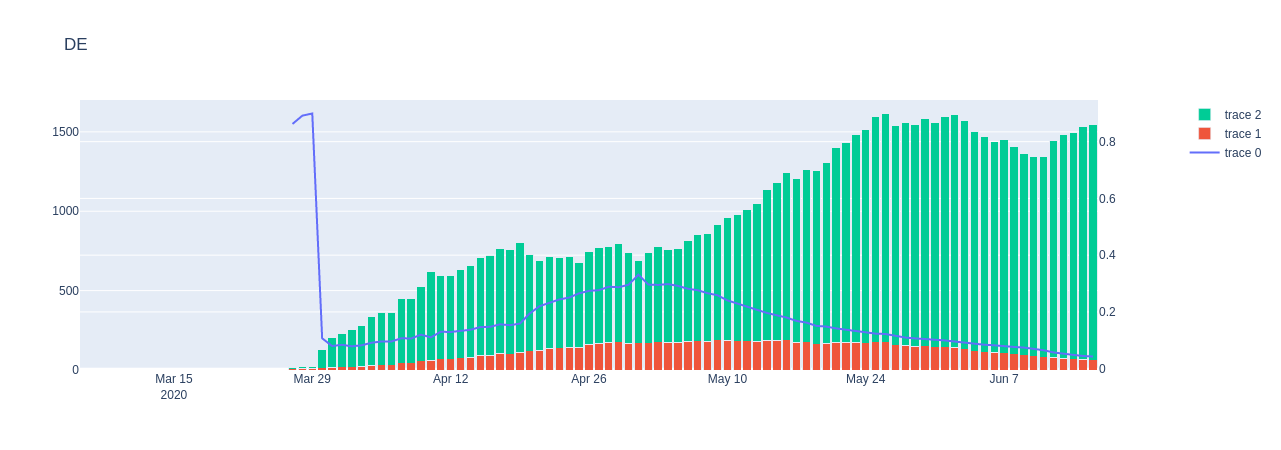

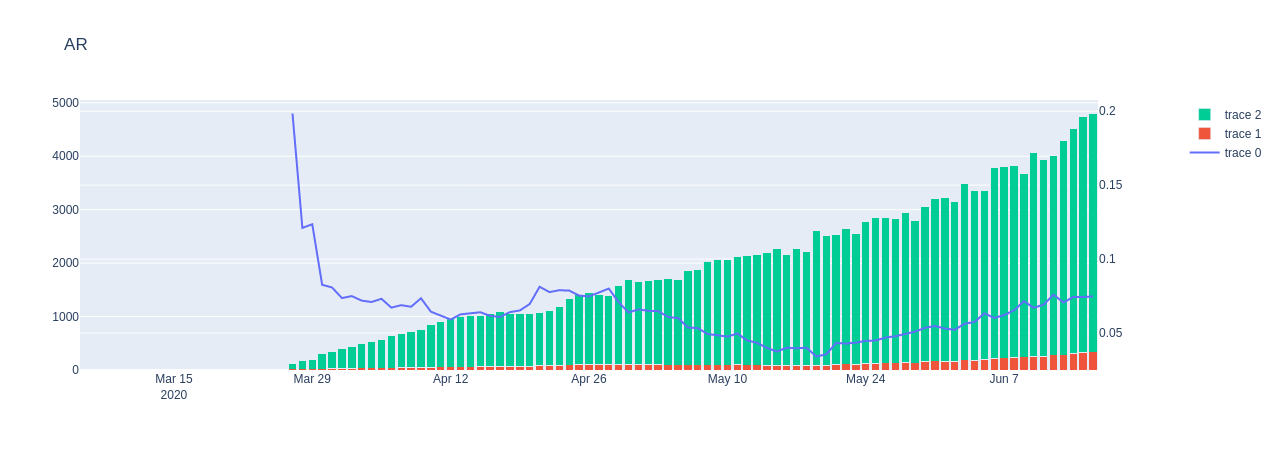

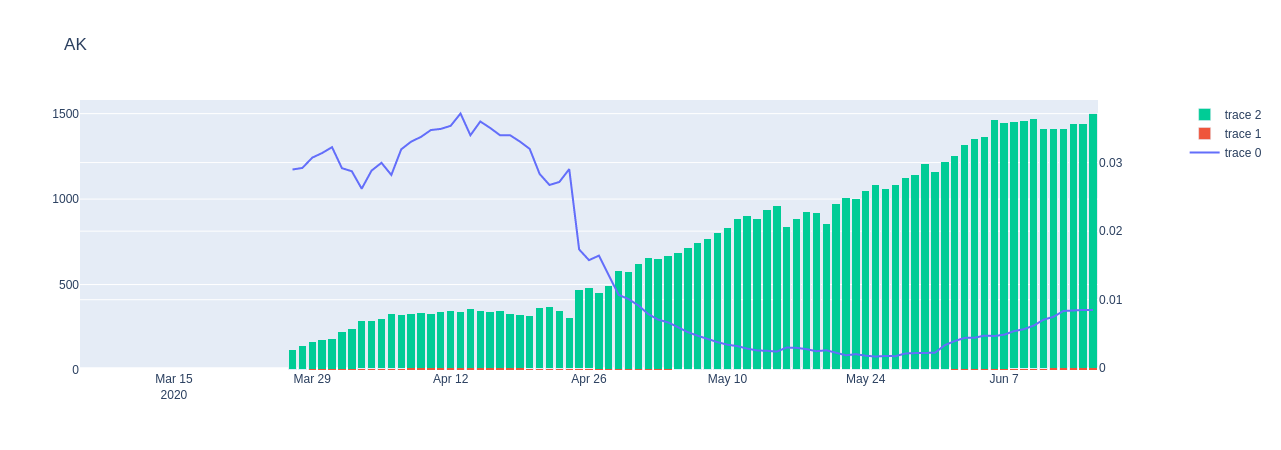

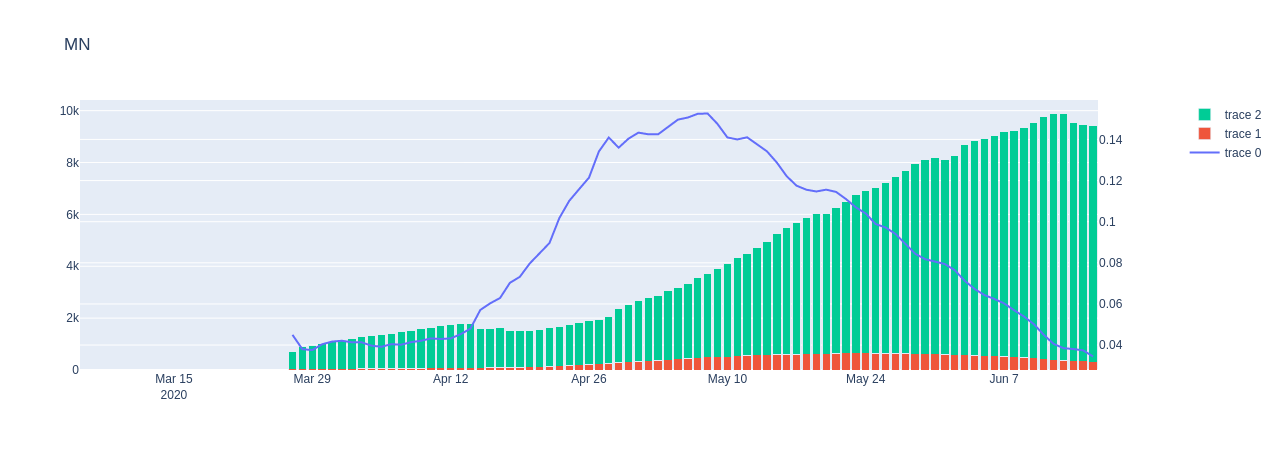

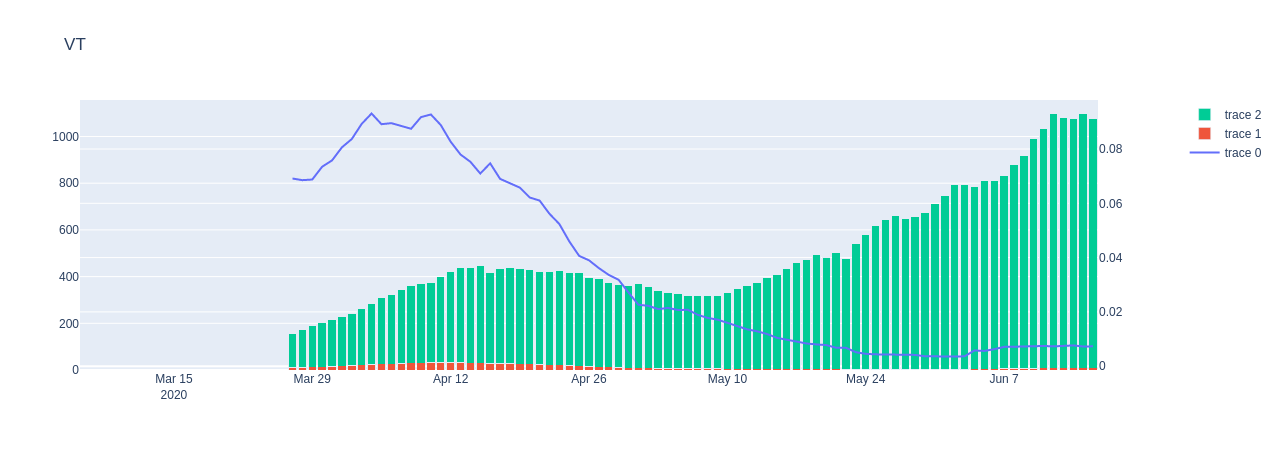

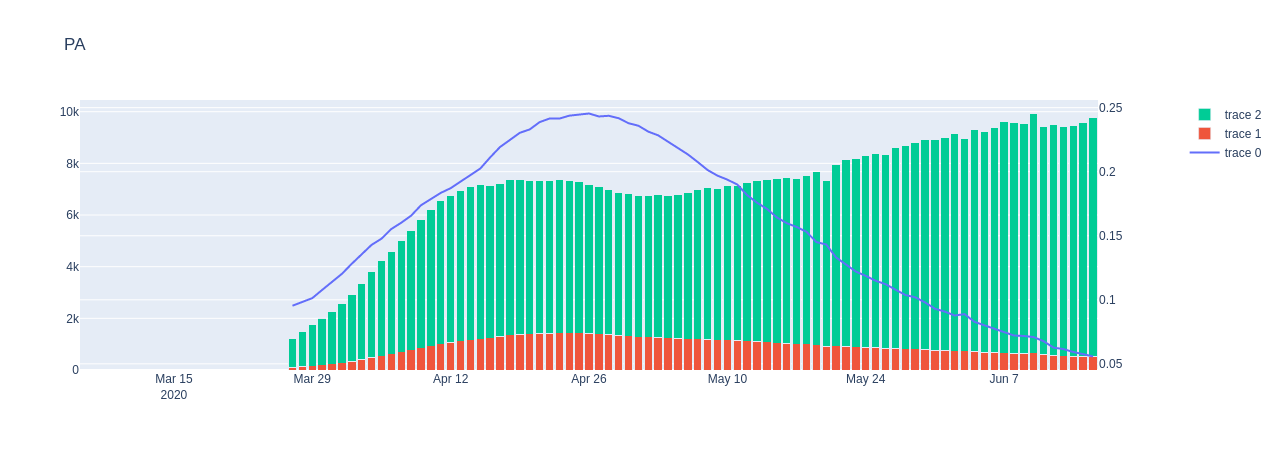

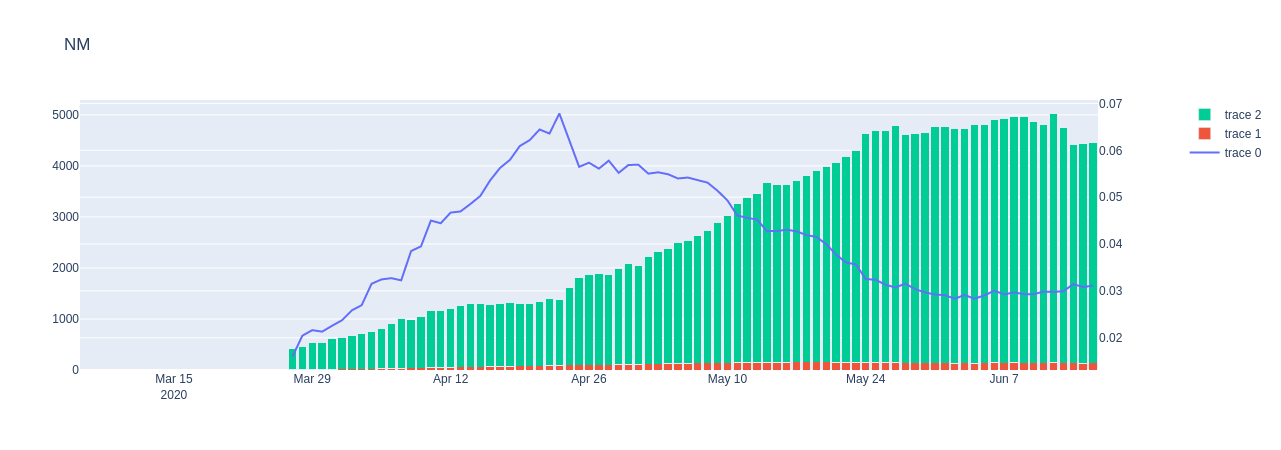

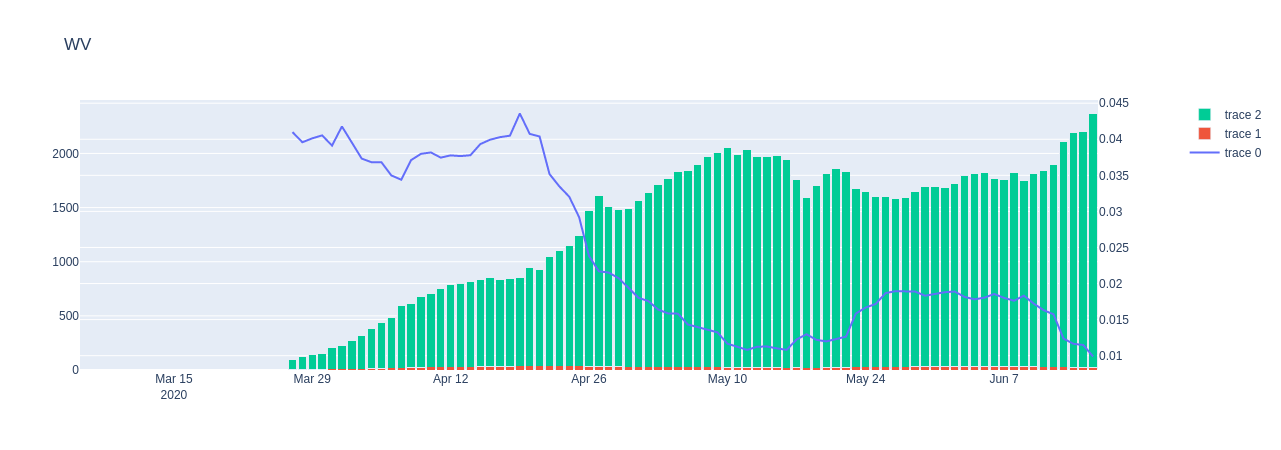

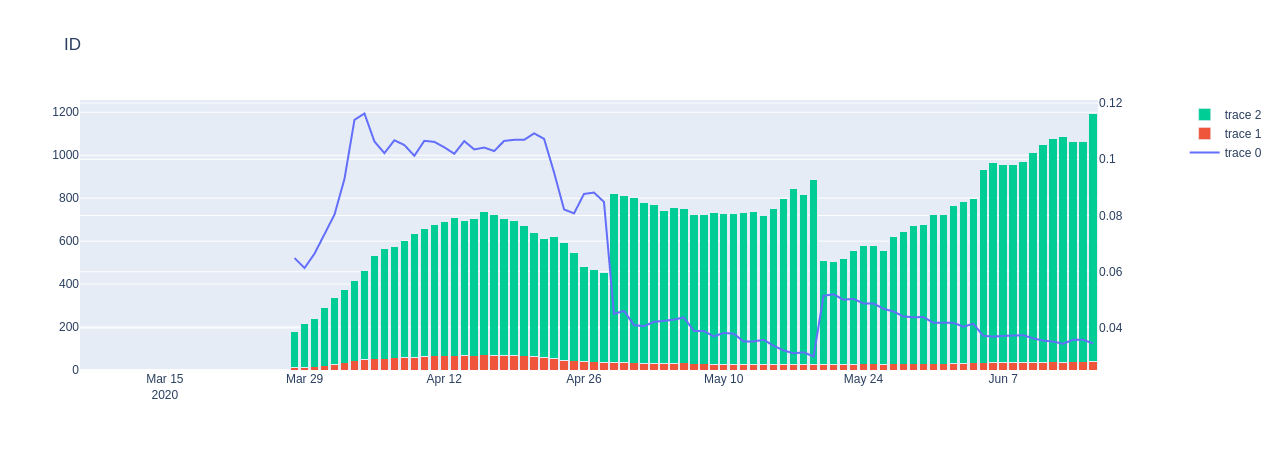

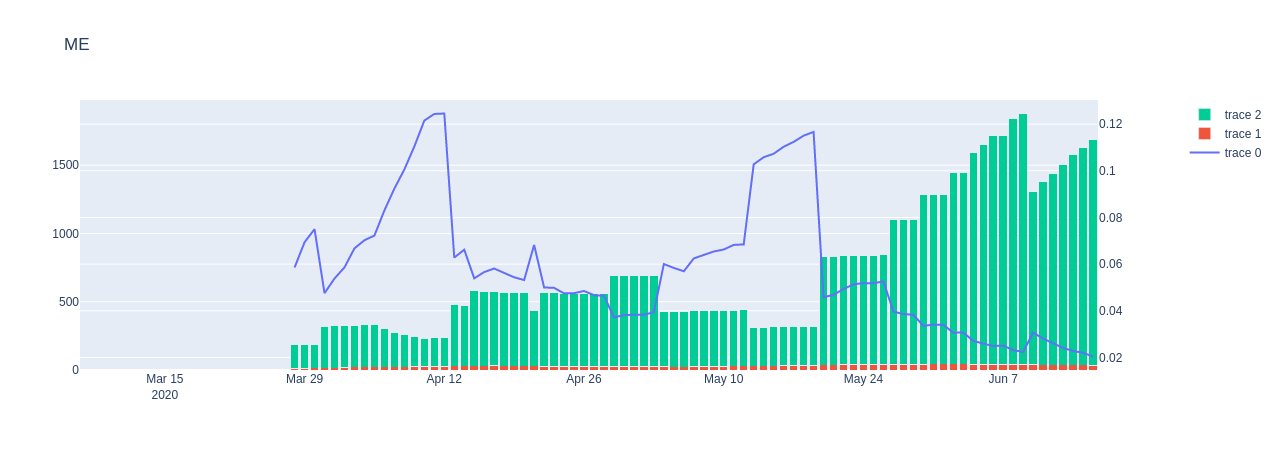

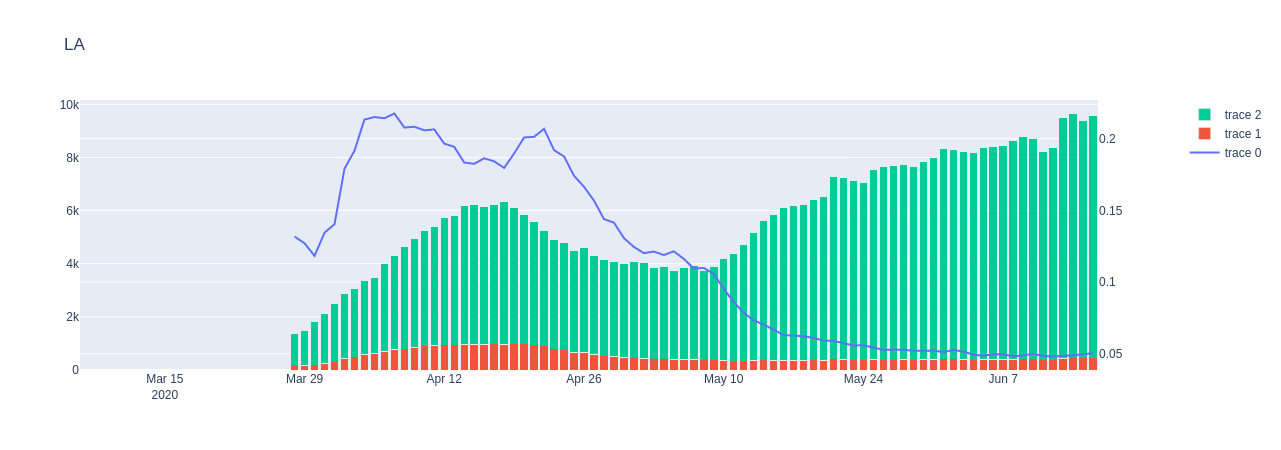

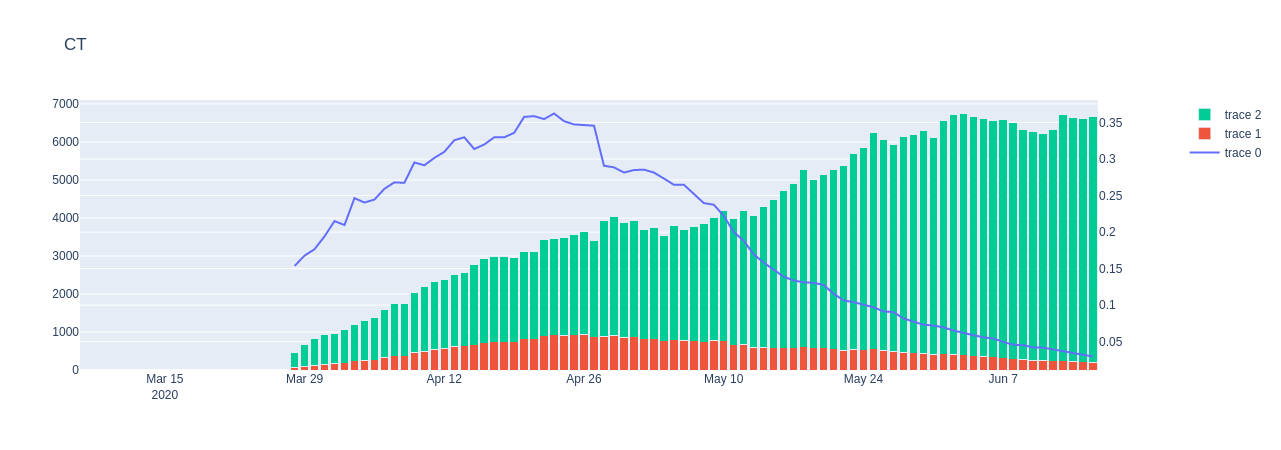

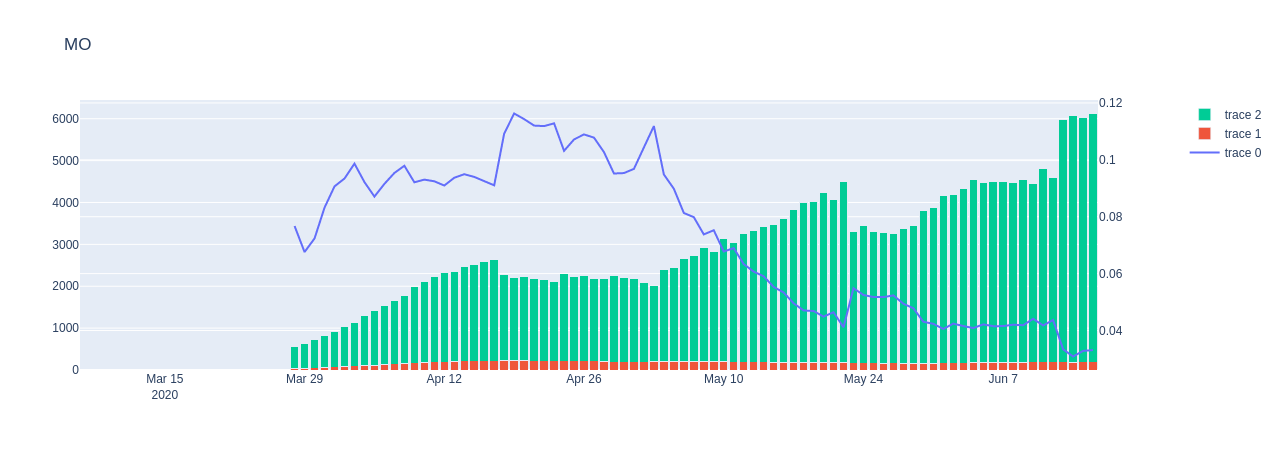

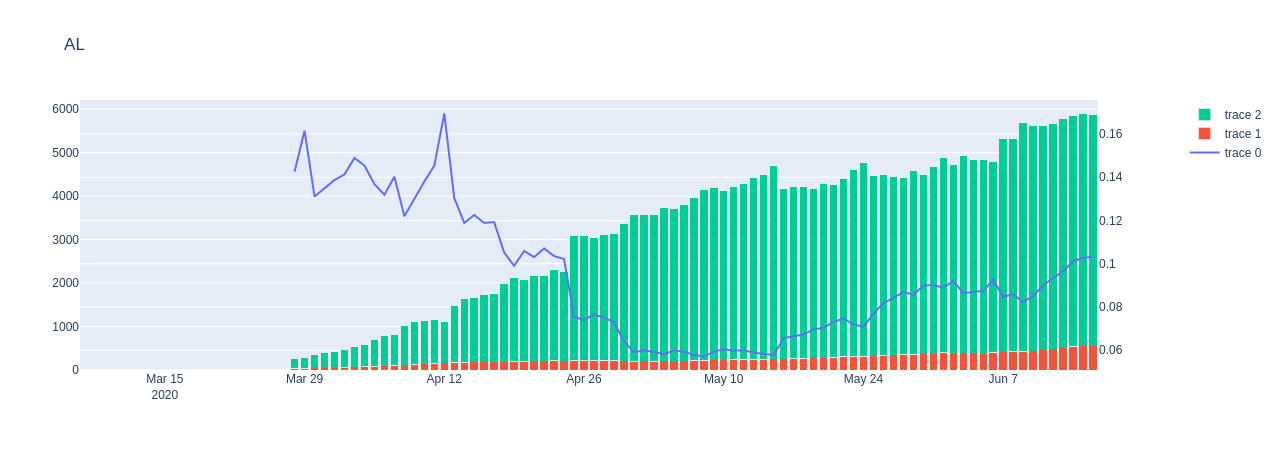

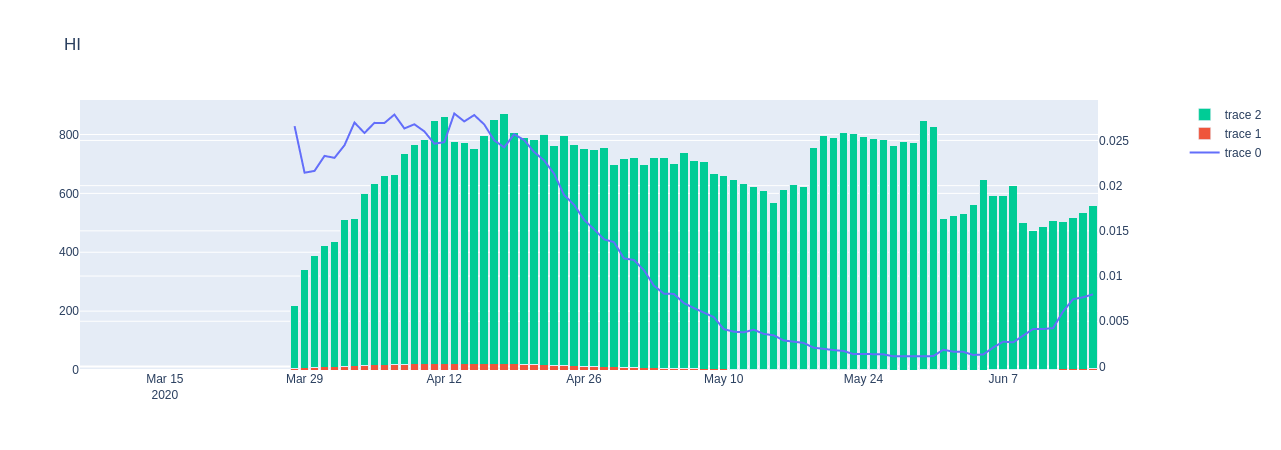

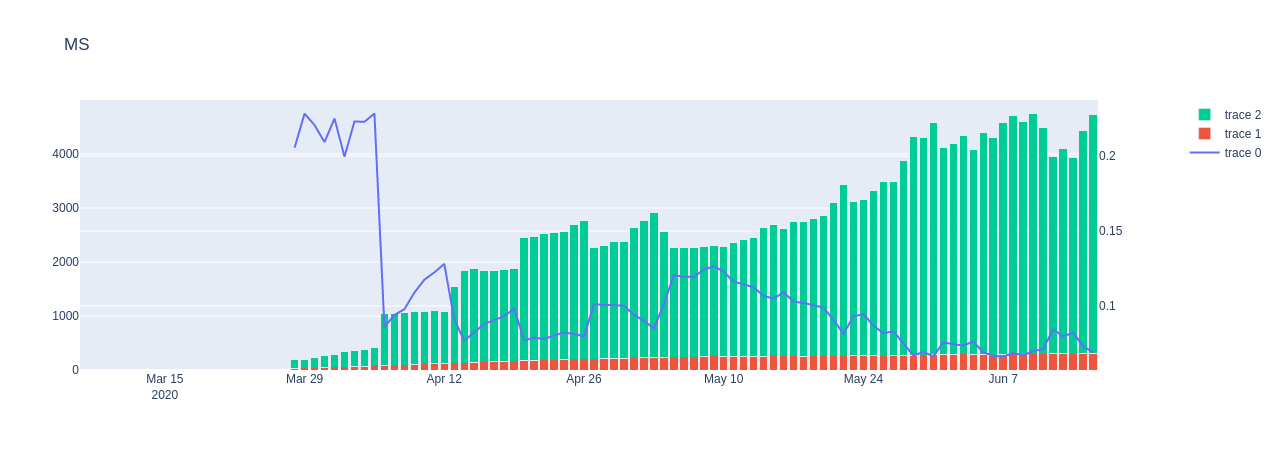

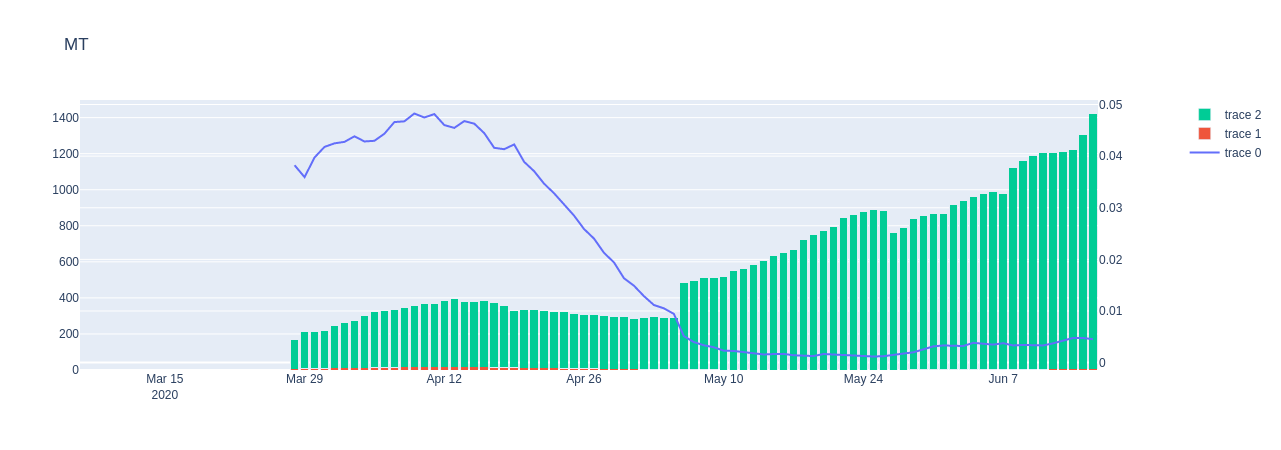

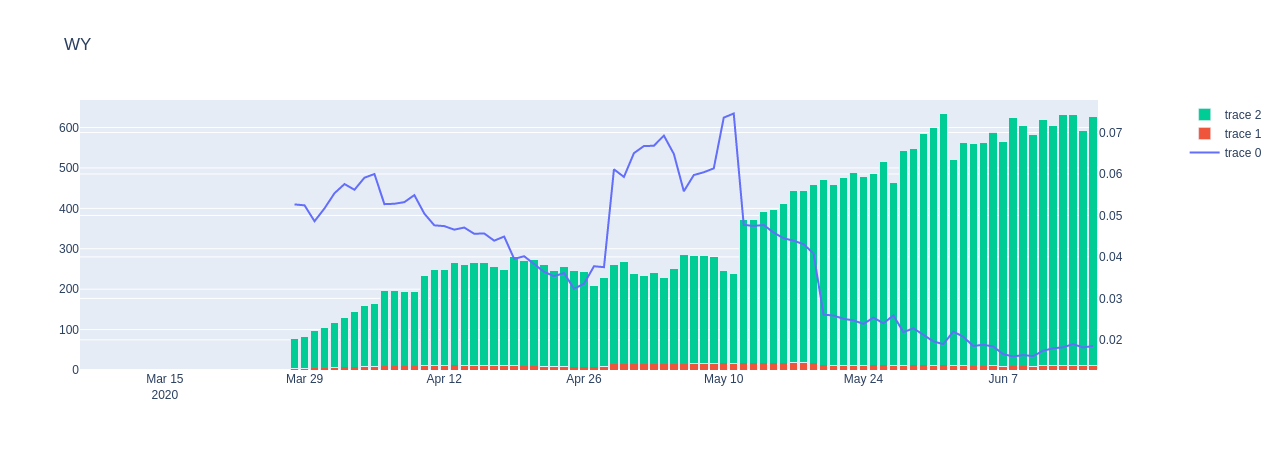

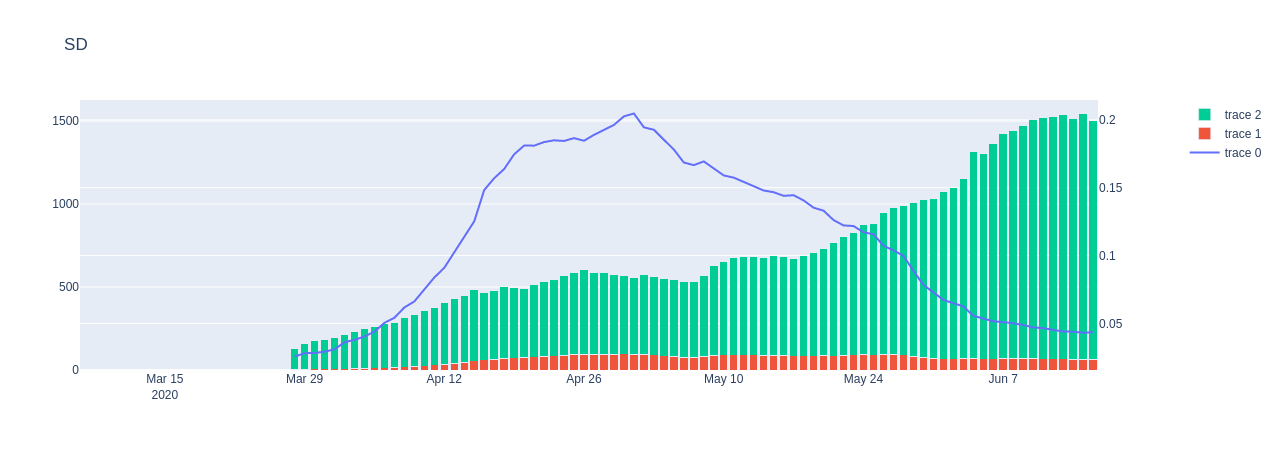

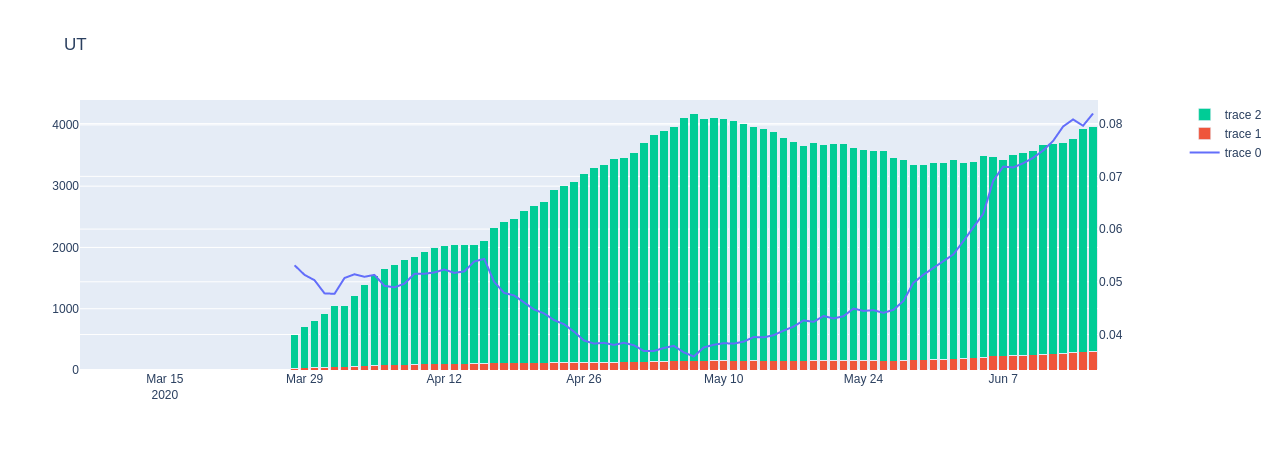

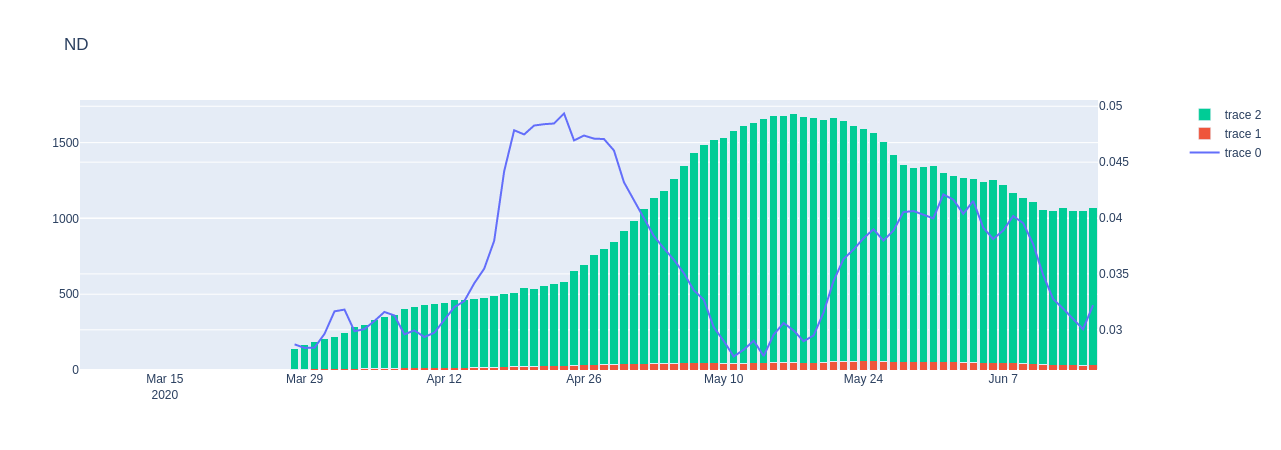

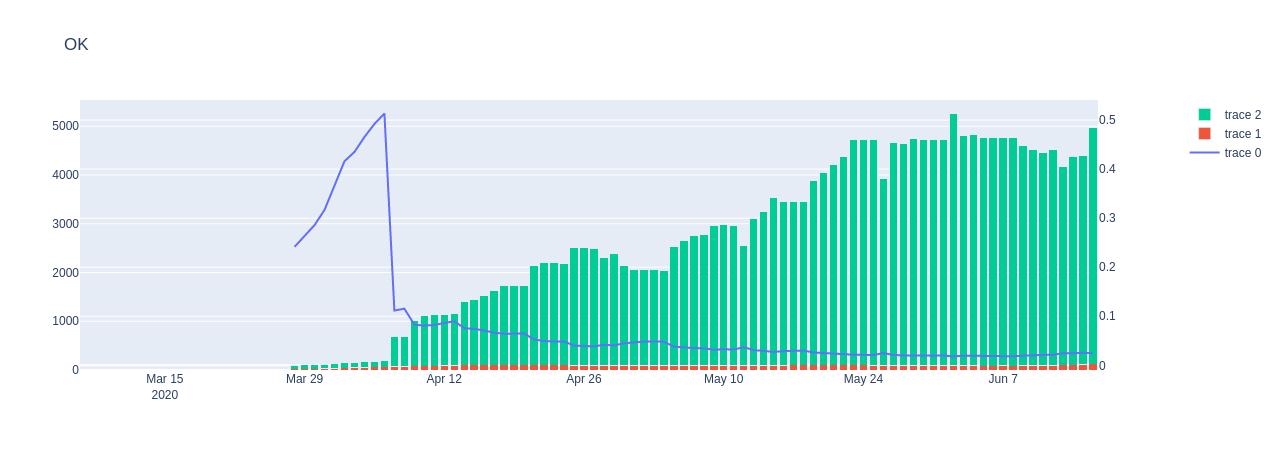

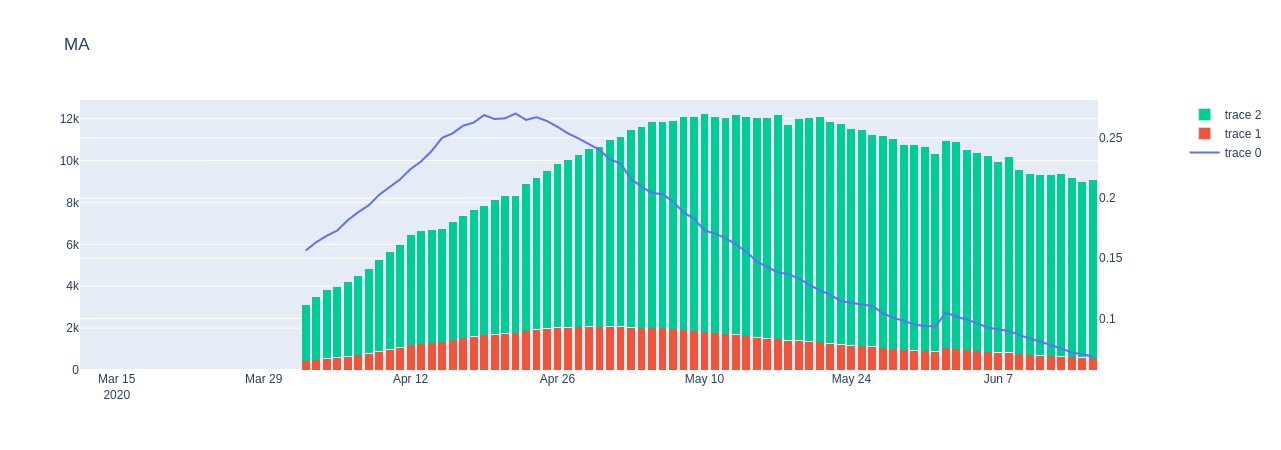

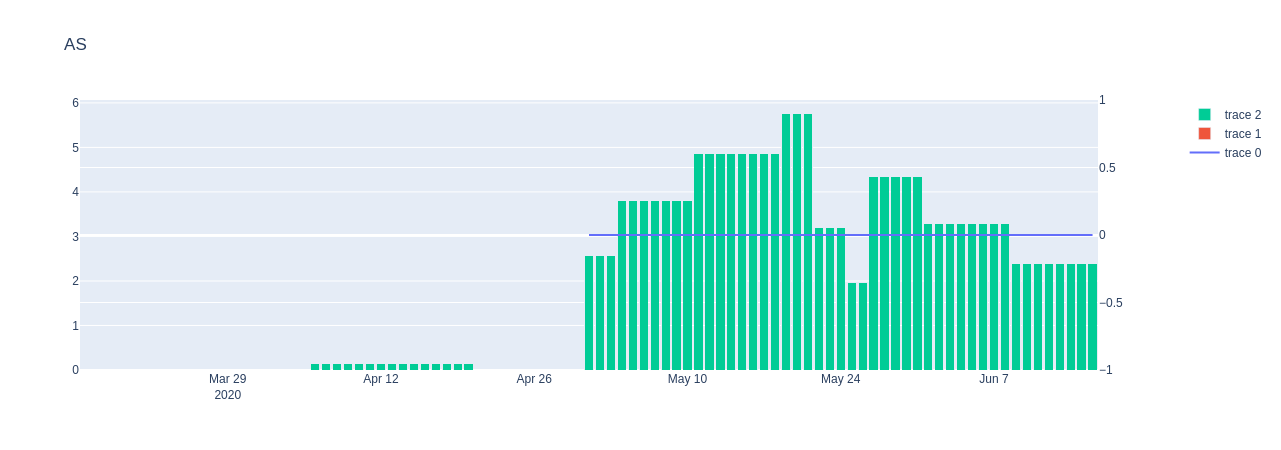

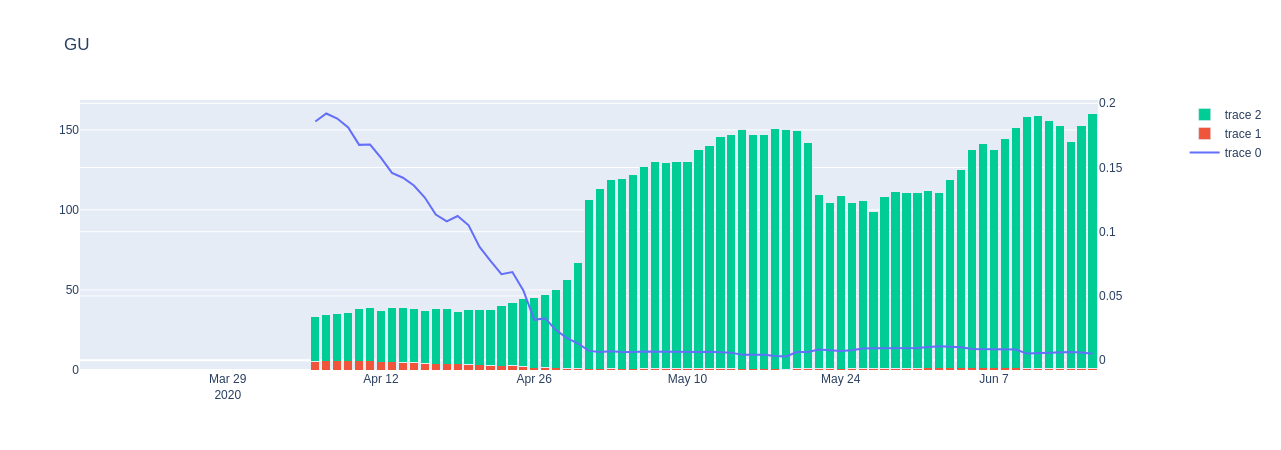

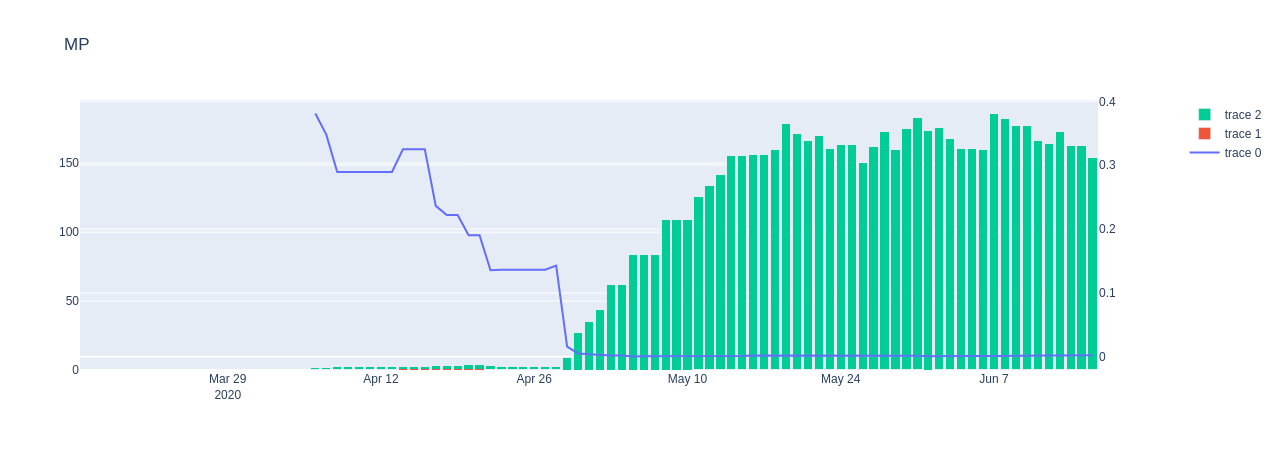

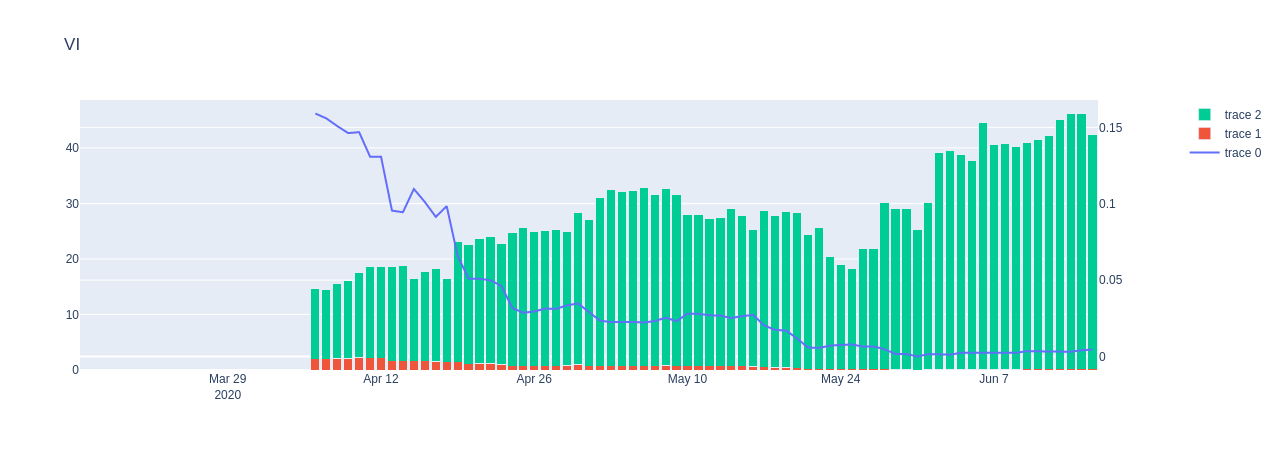

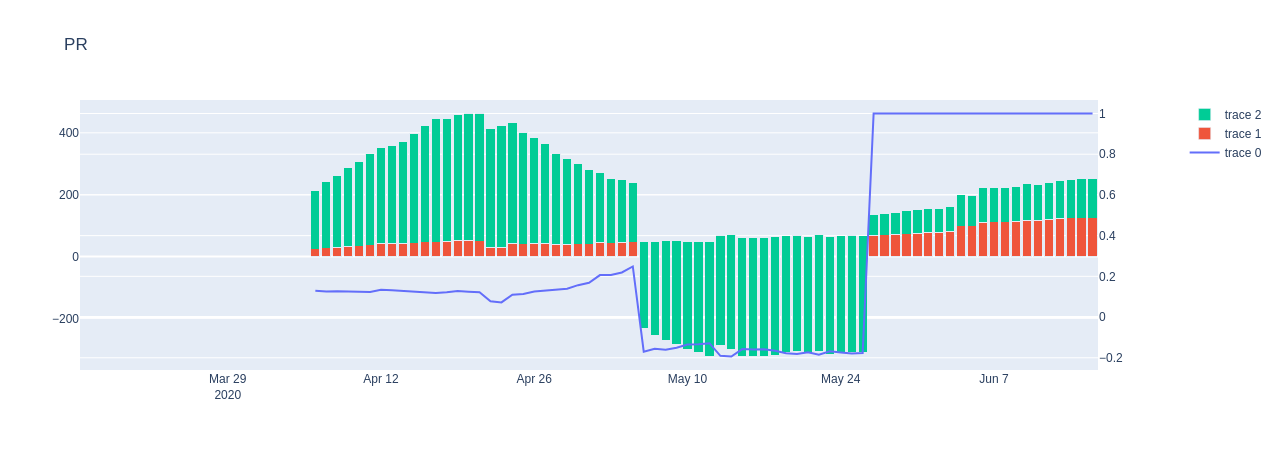

In [99]:
fig = make_subplots(specs = [[{"secondary_y": True}]])

for state in df.state.unique():
    
    if state in df.state.unique():
        tmp = df[df.state==state]
        tmp['deltapos'] = tmp.positive.diff()
        tmp['deltapos.rolling'] = tmp.deltapos.rolling(21).mean()
        tmp['deltatest'] = tmp.totalTestResults.diff()
        tmp['deltatest.rolling'] = tmp.deltatest.rolling(21).mean()
        fig.add_trace(
            go.Scatter(x = tmp.date, y = tmp['deltapos.rolling']/tmp['deltatest.rolling']),
            secondary_y = True
            )
        fig.add_trace(
            go.Bar(x = tmp.date, y = tmp['deltapos.rolling']),
            secondary_y = False
            )
        fig.add_trace(
            go.Bar(x = tmp.date, y = tmp['deltatest.rolling']),
            secondary_y = False
            )
#fig.update_yaxes(type="log")
        fig.update_layout(title = state,barmode = 'stack',
        #    autosize=False,
        #    width=1000,
        #    height=1000
        )
        fig.show()